# **PROYECTO 2**
# Predicción de Riesgo Cardiovascular y Decisión Clínica

El riesgo cardiovascular es la probabilidad de sufrir un evento del corazón o los vasos sanguíneos como infarto de miocardio, ictus, angina inestable o muerte cardiovascular, entre otros, en un periodo de tiempo (por ejemplo, en los próximos 5 a 10 años).

Para mejorar la prevención y la detección precoz del riesgo cardiovascular, se aplicaran técnicas estadísticas y de aprendizaje automático para identificar patrones, tendencias y correlaciones en un conjunto de datos clínicos recogidos en consulta. La base incluye variables objetivas (edad, altura, peso), de exploración (presión arterial sistólica/diastólica, colesterol, glucosa) y de estilo de vida (tabaquismo, alcohol, actividad física), a partir de las cuales derivaremos indicadores como el IMC (BMI).

El objetivo clínico es priorizar intervenciones (hábitos y fármacos) y vigilar de cerca a quienes muestren mayor probabilidad de evento cardiovascular en los próximos años

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import (roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
auc, brier_score_loss, make_scorer, f1_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay,
precision_score, recall_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

# Configuración reproducible
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Cargar dataset
DATA_PATH = "cardio_train.csv"
df = pd.read_csv(DATA_PATH, sep=';')
print('Cargado:', df.shape)

Cargado: (70000, 13)


In [2]:
df = df.copy()

# 1. Conocer BD
print("\nResumen estructural del DataFrame :")
df.info()
print("----------")
print("\nNúmero de valores únicos por columna:")
display(df.nunique())
print("----------")
print("\nPrimeras 5 filas del dataset:")
display(df.head())
print("----------")
print("\nMuestra aleatoria de filas:")
df.sample(3, random_state=42)


Resumen estructural del DataFrame :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB
----------

Número de valores únicos por columna:


id             70000
age             8076
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

----------

Primeras 5 filas del dataset:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


----------

Muestra aleatoria de filas:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
46730,66728,21770,1,156,64.0,140,80,2,1,0,0,1,1
48393,69098,21876,1,170,85.0,160,90,1,1,0,0,1,1
41416,59185,23270,1,151,90.0,130,80,1,1,0,0,1,1


In [3]:
# 1.1 Para evitar posibles errores
# Validación de forma y columnas
assert df.shape == (70000, 13), "Dimensiones inesperadas"
expected_cols = ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
                 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
assert list(df.columns) == expected_cols, "Columnas inesperadas"

# Verificación de nulos
assert df.isnull().sum().sum() == 0, "Hay valores nulos no esperados"

In [4]:
# 2. EDA breve y chequeos de rangos
print("\nDatos estadísticos básicos:")
display(df.drop(columns='id').describe(include='all').round(2))
print("----------")
print("\nPorcentaje de valores nulos por columna:")
display(df.isna().mean().sort_values(ascending=False))

# Balance de clases (cardio)
class_balance = df['cardio'].value_counts(normalize=True).sort_index()

print("Balance de clases (cardio):")
print(f"Sin riesgo (0): {class_balance[0]:.2%}")
print(f"En riesgo  (1): {class_balance[1]:.2%}")
print("----------")


Datos estadísticos básicos:


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.0,70000.0
mean,19468.87,1.35,164.36,74.21,128.82,96.63,1.37,1.23,0.09,0.05,0.8,0.5
std,2467.25,0.48,8.21,14.40,154.01,188.47,0.68,0.57,0.28,0.23,0.4,0.5
min,10798.00,1.00,55.00,10.00,-150.00,-70.00,1.00,1.00,0.00,0.00,0.0,0.0
25%,17664.00,1.00,159.00,65.00,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.0
50%,19703.00,1.00,165.00,72.00,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.0
75%,21327.00,2.00,170.00,82.00,140.00,90.00,2.00,1.00,0.00,0.00,1.0,1.0
max,23713.00,2.00,250.00,200.00,16020.00,11000.00,3.00,3.00,1.00,1.00,1.0,1.0


----------

Porcentaje de valores nulos por columna:


id             0.0
age            0.0
gender         0.0
height         0.0
weight         0.0
ap_hi          0.0
ap_lo          0.0
cholesterol    0.0
gluc           0.0
smoke          0.0
alco           0.0
active         0.0
cardio         0.0
dtype: float64

Balance de clases (cardio):
Sin riesgo (0): 50.03%
En riesgo  (1): 49.97%
----------


Columna age_years creada:


,age,age_years
0,18393,50.4
1,20228,55.4
2,18857,51.6
3,17623,48.2
4,17474,47.8


Edad mínima: 29.6, Edad máxima: 64.9
----------
Columna age_band creada:


,age_years,age_band
0,50.4,"[50,60)"
1,55.4,"[50,60)"
2,51.6,"[50,60)"
3,48.2,"[40,50)"
4,47.8,"[40,50)"


Distribución por banda de edad:


age_band
[0,40)      2.43 %
[40,50)    28.03 %
[50,60)    50.83 %
[60,70)    18.71 %
[70,+)       0.0 %
Name: count, dtype: object

----------


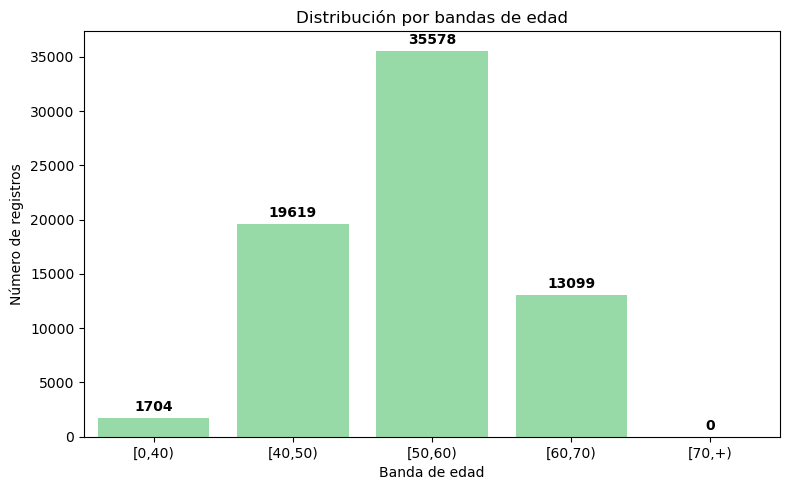

----------
Distribución por cuantiles de edad:


age_quantile
Q1    25.24 %
Q2    24.82 %
Q3    25.24 %
Q4     24.7 %
Name: proportion, dtype: object

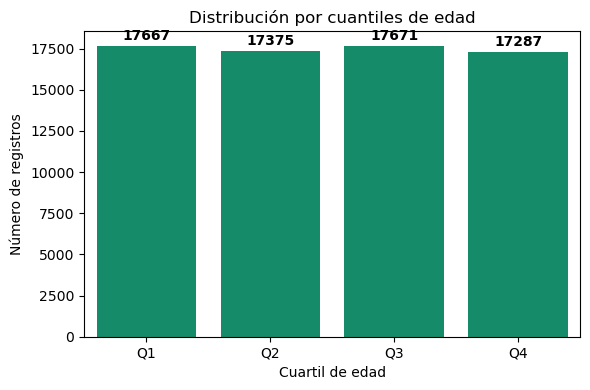

In [5]:
# 2.1 Age
# Edad en años
df['age_years']= (df['age']/365.25).round(1)
print("Columna age_years creada:")
display(df[['age', 'age_years']].head())
min_edad = df['age_years'].min()
max_edad = df['age_years'].max()
print(f"Edad mínima: {min_edad}, Edad máxima: {max_edad}")

assert min_edad >= 18, "Hay pacientes menores de edad"
assert max_edad <= 90, "Hay edades fuera del rango clínico adulto"

# Validar rango clínico adulto típico (18–90 años)
assert df['age_years'].between(18, 90).mean() > 0.99, "Edad fuera de rango clínico en >1%"
print("----------")

# age_band
age_bins = [0, 40, 50, 60, 70, np.inf]
age_labels = ['[0,40)', '[40,50)', '[50,60)', '[60,70)', '[70,+)']
df['age_band'] = pd.cut(df['age_years'], bins=age_bins, labels=age_labels, right=False)
print("Columna age_band creada:")
display(df[['age_years', 'age_band']].head())

# Validar: no debe haber valores sin asignar en age_band
nulos_age_band = df['age_band'].isna().sum()
assert nulos_age_band == 0, f"Hay {nulos_age_band} registros fuera de los rangos definidos"

age_band_dist = df['age_band'].value_counts(sort=False)
print("Distribución por banda de edad:")
display((age_band_dist / len(df) * 100).round(2).astype(str) + " %")
print("----------")

# Visualización
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='age_band', data=df, order=age_labels, color=sns.color_palette("pastel")[2])
plt.title("Distribución por bandas de edad")
plt.xlabel("Banda de edad")
plt.ylabel("Número de registros")

for i, count in enumerate(age_band_dist.values):
    ax.text(i, count + max(age_band_dist.values) * 0.01, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig("figures/P2_distrib_age_band.png", dpi=120)
plt.show()
print("----------")

# Edad por cuantiles
df['age_quantile'] = pd.qcut(df['age_years'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Validar: no debe haber valores sin asignar en age_quantile
nulos_age_quantile = df['age_quantile'].isna().sum()
assert nulos_age_quantile == 0, f"Hay {nulos_age_quantile} registros fuera de los cuartiles definidos"

age_quantile_dist = df['age_quantile'].value_counts(normalize=True).sort_index() * 100
print("Distribución por cuantiles de edad:")
display(age_quantile_dist.round(2).astype(str) + " %")

# Visualización
conteo = df['age_quantile'].value_counts().sort_index()
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='age_quantile', data=df, order=['Q1', 'Q2', 'Q3', 'Q4'], color=sns.color_palette("colorblind")[2])
plt.title("Distribución por cuantiles de edad")
plt.xlabel("Cuartil de edad")
plt.ylabel("Número de registros")

for i, valor in enumerate(conteo.values):
    ax.text(i, valor + max(conteo.values) * 0.01, str(valor), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig("figures/P2_distrib_age_quantile.png", dpi=120)
plt.show()

Columna BMI creada:


,weight,height,BMI
0,62.0,168,21.97
1,85.0,156,34.93
2,64.0,165,23.51
3,82.0,169,28.71
4,56.0,156,23.01


----------
Distribución de BMI por rangos (OMS):
BMI_cat
Bajo peso     0.92%
Normopeso    36.65%
Obesidad     26.46%
Sobrepeso    35.96%
Name: proportion, dtype: object


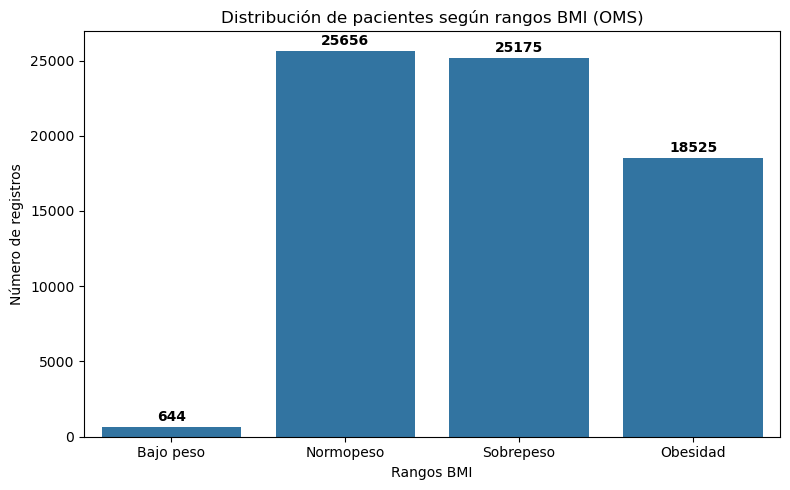

In [6]:
# 2.2 BMI
df['BMI'] = (df['weight'] / ((df['height'] / 100) ** 2)).round(2)
print("Columna BMI creada:")
display(df[['weight', 'height', 'BMI']].head())

# Validar rango clínico plausible (10–80 kg/m²)
assert df['BMI'].between(10, 80).mean() > 0.99, "BMI fuera de rango clínico en >1%"
print("----------")

# Clasificación de BMI según rangos OMS
def clasificar_bmi(bmi):
    if bmi < 18.5:
        return "Bajo peso"
    elif bmi < 25:
        return "Normopeso"
    elif bmi < 30:
        return "Sobrepeso"
    else:
        return "Obesidad"
df['BMI_cat'] = df['BMI'].apply(clasificar_bmi)

# Validación: distribución por categoría
bmi_dist = df['BMI_cat'].value_counts(normalize=True).sort_index()
print("Distribución de BMI por rangos (OMS):")
print((bmi_dist * 100).round(2).astype(str) + "%")

# Visualización
orden_bmi = ["Bajo peso", "Normopeso", "Sobrepeso", "Obesidad"]
conteos = df['BMI_cat'].value_counts().reindex(orden_bmi)

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='BMI_cat', data=df, order=orden_bmi)
plt.title("Distribución de pacientes según rangos BMI (OMS)")
plt.xlabel("Rangos BMI")
plt.ylabel("Número de registros")

for i, count in enumerate(conteos):
    ax.text(i, count + 200, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig("figures/P2_distrib_bmi.png", dpi = 120)
plt.show()

In [7]:
# 2.3 PA - Verificar coherencia
# Crear flag de incoherencia: ap_lo ≥ ap_hi
df['flag_ap_incoherent'] = (df['ap_lo'] >= df['ap_hi']).astype(int)

# Validar proporción de incoherencias
incoherent_pct = df['flag_ap_incoherent'].mean()
print(f"Proporción de registros con ap_lo ≥ ap_hi: {incoherent_pct:.2%}")

# Exclusión cuando calcule PA
df = df[df['flag_ap_incoherent'] == 0].copy()

# Validación
n_excluidas = df['flag_ap_incoherent'].sum()
pct_excluidas = n_excluidas / (n_excluidas + len(df)) * 100
print(f"Filas excluidas por incoherencia: {n_excluidas} ({pct_excluidas:.2f}%)")

# Flag HTA (ap_hi ≥130 , ap_lo ≥80)
def clasificar_ap_hi(val):
    if val < 120:
        return "normal"
    elif val < 130:
        return "elevada"
    else:
        return "HTA"
df['ap_hi_cat'] = df['ap_hi'].apply(clasificar_ap_hi)

def clasificar_ap_lo(val):
    if val < 80:
        return "normal"
    else:
        return "HTA"
df['ap_lo_cat'] = df['ap_lo'].apply(clasificar_ap_lo)

df['flag_HTA'] = ((df['ap_hi_cat'] == "HTA") | (df['ap_lo_cat'] == "HTA")).astype(int)

# Validación: proporción de registros con flag HTA
flag_hta = df['flag_HTA'].mean()
print(f"Proporción de registros con alerta HTA: {flag_hta:.2%}")

Proporción de registros con ap_lo ≥ ap_hi: 1.77%
Filas excluidas por incoherencia: 0 (0.00%)
Proporción de registros con alerta HTA: 81.53%



Distribución de 'cholesterol' (ordinal 1 < 2 < 3):


cholesterol
1    74.99 %
2    13.55 %
3    11.46 %
Name: proportion, dtype: object

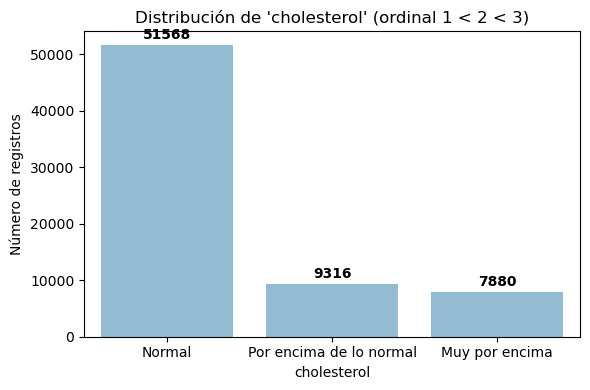


Distribución de 'gluc' (ordinal 1 < 2 < 3):


gluc
1    85.03 %
2     7.37 %
3     7.59 %
Name: proportion, dtype: object

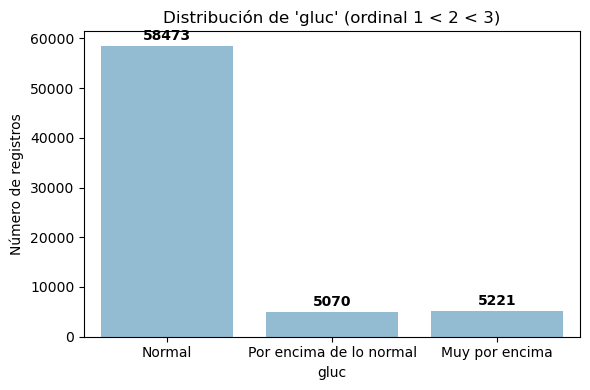


Distribución de 'smoke' (binaria 0 = no, 1 = sí):


smoke
0    91.21 %
1     8.79 %
Name: proportion, dtype: object

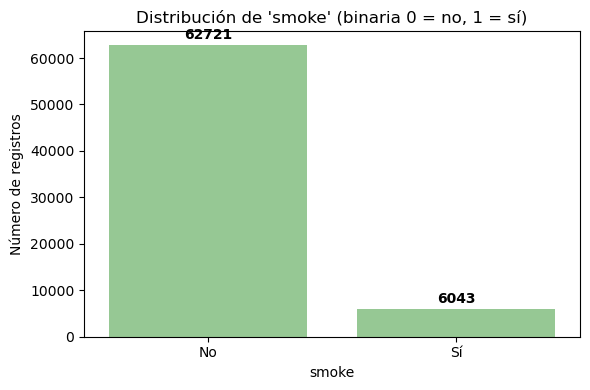


Distribución de 'alco' (binaria 0 = no, 1 = sí):


alco
0    94.67 %
1     5.33 %
Name: proportion, dtype: object

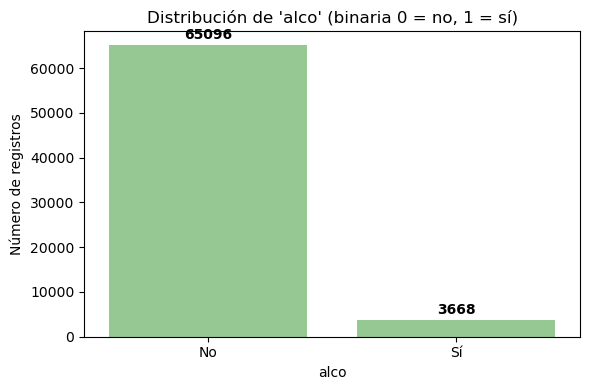


Distribución de 'active' (binaria 0 = no, 1 = sí):


active
0    19.65 %
1    80.35 %
Name: proportion, dtype: object

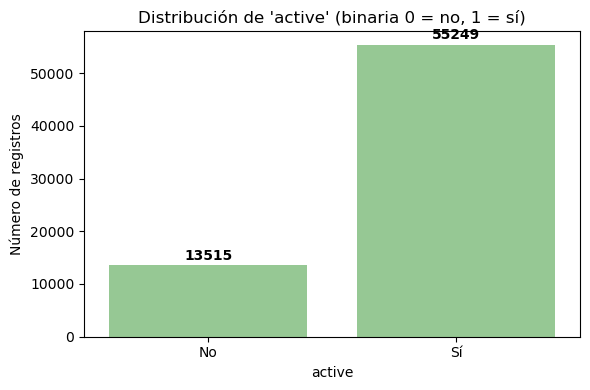


Distribución por sexo (1 = mujer, 2 = hombre):


gender
1    65.14 %
2    34.86 %
Name: proportion, dtype: object

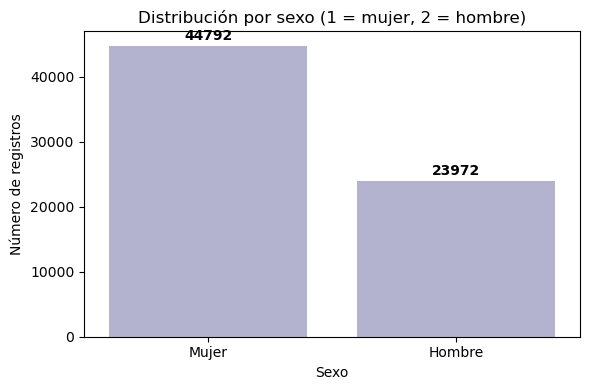

In [8]:
# 2.4 Codificación variables categóricas
# Validar codificación cholesterol y gluc
for col in ['cholesterol', 'gluc']:
    print(f"\nDistribución de '{col}' (ordinal 1 < 2 < 3):")
    display((df[col].value_counts(normalize=True).sort_index() * 100).round(2).astype(str) + " %")
    
    conteo = df[col].value_counts().sort_index()
    etiquetas = {1: 'Normal', 2: 'Por encima de lo normal', 3: 'Muy por encima'}
    nombres = [etiquetas.get(i, str(i)) for i in conteo.index]

    plt.figure(figsize=(6, 4))
    ax = sns.barplot(x=nombres, y=conteo.values, color=sns.color_palette("Blues")[2])
    plt.title(f"Distribución de '{col}' (ordinal 1 < 2 < 3)")
    plt.xlabel(col)
    plt.ylabel("Número de registros")

    for i, valor in enumerate(conteo.values):
        ax.text(i, valor + max(conteo.values) * 0.01, str(valor), ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig(f"figures/P2_codificacion_{col}.png", dpi = 120)
    plt.show()

# Validar codificación: smoke, alco, active
for col in ['smoke', 'alco', 'active']:
    print(f"\nDistribución de '{col}' (binaria 0 = no, 1 = sí):")
    display((df[col].value_counts(normalize=True).sort_index() * 100).round(2).astype(str) + " %")

    conteo = df[col].value_counts().sort_index()
    etiquetas = {0: 'No', 1: 'Sí'}
    nombres = [etiquetas.get(i, str(i)) for i in conteo.index]

    plt.figure(figsize=(6, 4))
    ax = sns.barplot(x=nombres, y=conteo.values, color=sns.color_palette("Greens")[2])
    plt.title(f"Distribución de '{col}' (binaria 0 = no, 1 = sí)")
    plt.xlabel(col)
    plt.ylabel("Número de registros")

    for i, valor in enumerate(conteo.values):
        ax.text(i, valor + max(conteo.values) * 0.01, str(valor), ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig(f"figures/P2_codificacion_{col}.png", dpi = 120)
    plt.show()

# Validar codificación de género
print("\nDistribución por sexo (1 = mujer, 2 = hombre):")
display((df['gender'].value_counts(normalize=True).sort_index() * 100).round(2).astype(str) + " %")

conteo = df['gender'].value_counts().sort_index()
etiquetas = {1: 'Mujer', 2: 'Hombre'}
nombres = [etiquetas.get(i, str(i)) for i in conteo.index]

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=nombres, y=conteo.values, color=sns.color_palette("Purples")[2])
plt.title("Distribución por sexo (1 = mujer, 2 = hombre)")
plt.xlabel("Sexo")
plt.ylabel("Número de registros")

for i, valor in enumerate(conteo.values):
    ax.text(i, valor + max(conteo.values) * 0.01, str(valor), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig("figures/P2_codificacion_sexo.png", dpi = 120)
plt.show()

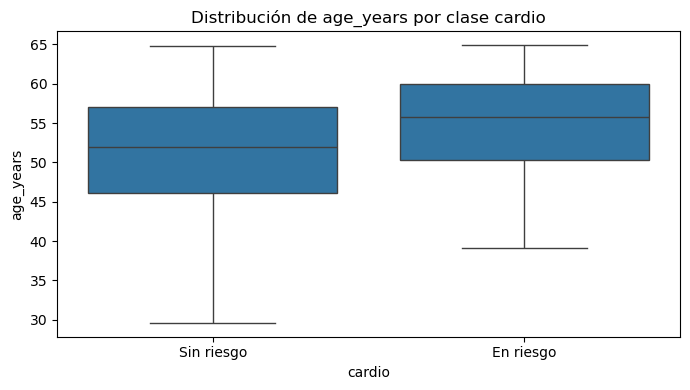

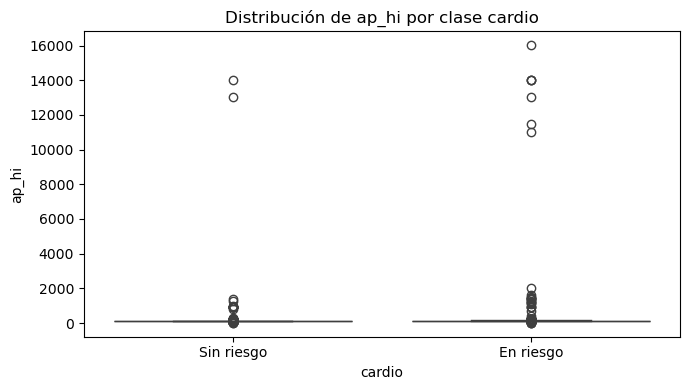

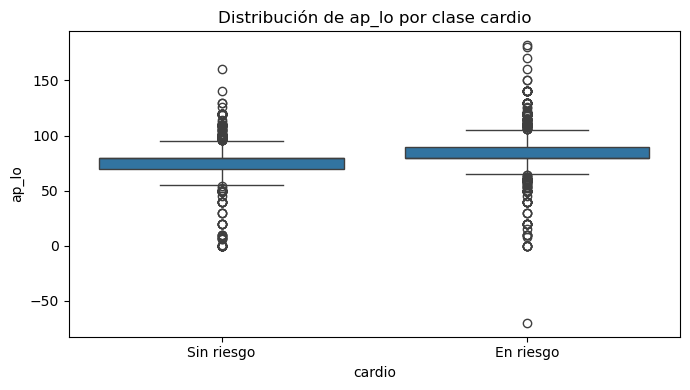

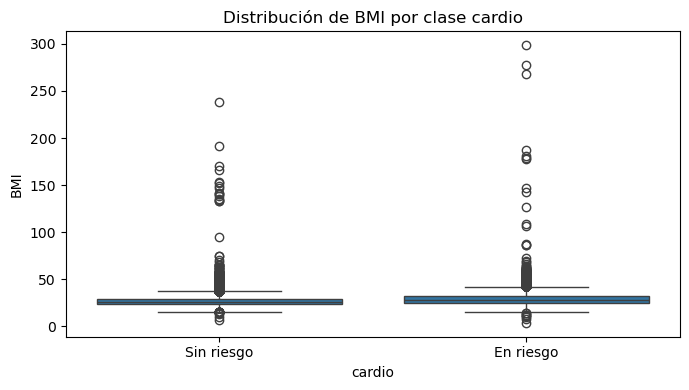

In [9]:
# 2.5 Boxplots por clase cardio para variables numéricas
# Variables numéricas relevantes para EDA
num_vars = ['age_years', 'ap_hi', 'ap_lo', 'BMI']

for var in num_vars:
    plt.figure(figsize=(7, 4))
    sns.boxplot(x='cardio', y=var, data=df)
    plt.title(f"Distribución de {var} por clase cardio")
    plt.xlabel("cardio")
    plt.ylabel(var)
    plt.xticks([0, 1], ["Sin riesgo", "En riesgo"])
    plt.tight_layout()
    plt.savefig(f"figures/P2_boxplot_{var}_by_cardio.png", dpi = 120)
    plt.show()

En el ***BMI*** **por clase** ***cardio*** se puede comprobar que **no discrimina bien por sí solo**, pero puede aportar valor combinado con otras variables (ej. colesterol, edad). Se en cuentran outliers frecuentes en ambos extremos, especialmente por en valores de **BMI** > 40 kg/m<sup>2<sup>.

La ***ap_lo*** **por clase** ***cardio*** muestra una **cierta discriminación** (el grupo en riesgo muestra una mediana más alta y una distribución más compacta, mientras que el grupo sin riesgo tiene más dispersión y outliers extremos), útil para la flag de hipertensión diastólica.

La ***ap_hi*** **por clase** ***cardio*** es un **buen discriminador** (el grupo en riesgo tiene una mediana claramente más alta y mayor dispersión los outliers extremos están por encima de 180–200 mmHg en este grupo). Se puede derivar una flag_htn_sistolica = (*ap_hi* ≥ 140 mmHg).

La ***age_years*** **por clase** ***cardio*** es un **predictor relevante** (el grupo en riesgo tiene una mediana más alta y la distribución es más compacta, con menos dispersión inferior). Se puede usar para estratificar ya que el patrón sugiere que el riesgo cardiovascular aumenta con la edad, como era esperable.

Por todo ello, crearé una flag de riesgo clínico:

Distribución de 'flag_riesgo_clinico':


flag_riesgo_clinico
1    55.26 %
0    44.74 %
Name: proportion, dtype: object

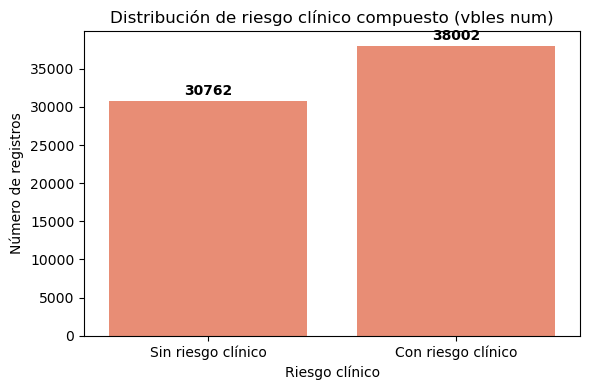

In [10]:
# Flag de riesgo clínico
df['flag_riesgo_clinico'] = (
    (df['ap_hi'] >= 140) |
    (df['ap_lo'] >= 90) |
    (df['BMI'] >= 30) |
    (df['age_years'] >= 60)
).astype(int)

print("Distribución de 'flag_riesgo_clinico':")
display((df['flag_riesgo_clinico'].value_counts(normalize=True) * 100).round(2).astype(str) + " %")

conteo = df['flag_riesgo_clinico'].value_counts().sort_index()
etiquetas = {0: 'Sin riesgo clínico', 1: 'Con riesgo clínico'}

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=[etiquetas[i] for i in conteo.index], y=conteo.values, color=sns.color_palette("Reds")[2])
plt.title("Distribución de riesgo clínico compuesto (vbles num)")
plt.xlabel("Riesgo clínico")
plt.ylabel("Número de registros")

for i, valor in enumerate(conteo.values):
    ax.text(i, valor + max(conteo.values) * 0.01, str(valor), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig("figures/P2_flag_riesgo_clinico.png", dpi=120)
plt.show()

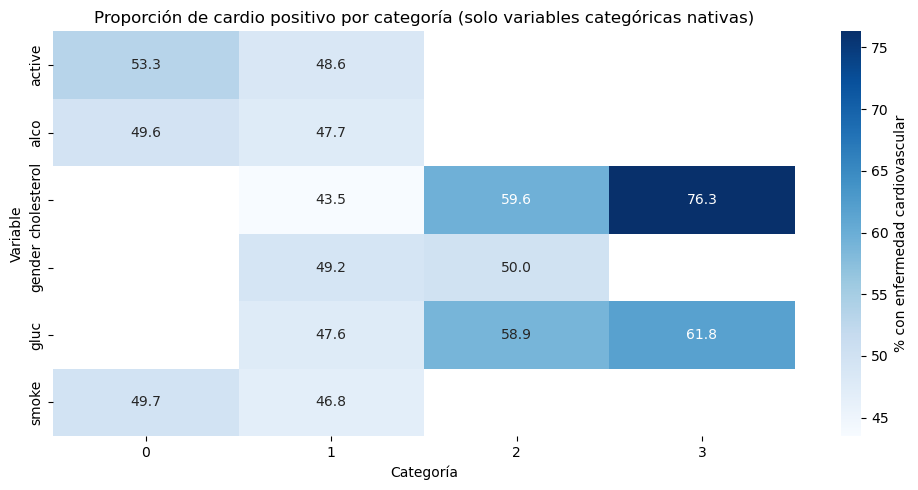

In [11]:
# 2.6 Heatmap por clase cardio para variables categóricas
vars_cat = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

# Construir tabla cruzada
tabla = pd.DataFrame()

for var in vars_cat:
    cruzada = pd.crosstab(df[var], df['cardio'], normalize='index') * 100
    cruzada = cruzada.round(1)
    cruzada['variable'] = var
    cruzada['categoria'] = cruzada.index
    tabla = pd.concat([tabla, cruzada])

tabla_pivot = tabla.pivot(index='variable', columns='categoria', values=1)  # columna 1 = cardio positivo

plt.figure(figsize=(10, 5))
sns.heatmap(tabla_pivot, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label': '% con enfermedad cardiovascular'})
plt.title("Proporción de cardio positivo por categoría (solo variables categóricas nativas)")
plt.xlabel("Categoría")
plt.ylabel("Variable")
plt.tight_layout()
plt.savefig("figures/P2_heatmap_cardio_vs_categoricas.png", dpi=120)
plt.show()

**Análisis por variable**

El ***cholesterol*** muestra una **fuerte asociación positiva**. Con la categoría muy alta con un ~75% con enfermedad cardiovascular

La ***gluc*** muestra un **patrón similar** con la categoría de prevalencia más alta

En el ***gender***, el **sexo masculino** muestra **mayor riesgo**.

En el ***smoke*** hay una **diferencia leve** entre fumadores y no fumadores y por tanto, no parece ser un discriminador fuerte.

Con el ***alco***, su **consumo** está asociado a un **mayor riesgo**.

Y en la ***active***, el **sedentarismo** es un **factor de riesgo**.

Por todo ello, voy a crear una flag riesgo de estilo de vida.

Distribución de 'flag_riesgo_estilo_vida':


flag_riesgo_estilo_vida
0    70.73 %
1    29.27 %
Name: proportion, dtype: object

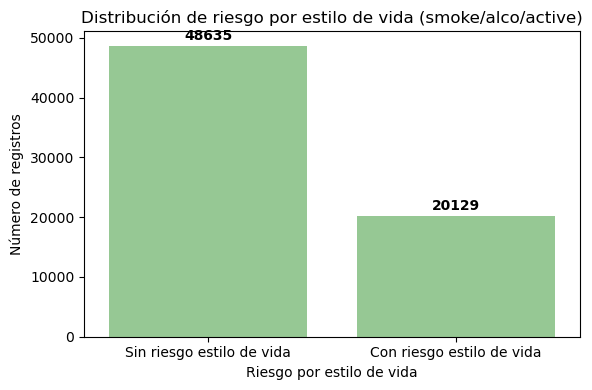

In [12]:
# Flag riesgo de estilo de vida
df['flag_riesgo_estilo_vida'] = (
    (df['smoke'] == 1) |
    (df['alco'] == 1) |
    (df['active'] == 0)
).astype(int)

print("Distribución de 'flag_riesgo_estilo_vida':")
display((df['flag_riesgo_estilo_vida'].value_counts(normalize=True) * 100).round(2).astype(str) + " %")

conteo = df['flag_riesgo_estilo_vida'].value_counts().sort_index()
etiquetas = {0: 'Sin riesgo estilo de vida', 1: 'Con riesgo estilo de vida'}

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=[etiquetas[i] for i in conteo.index], y=conteo.values, color=sns.color_palette("Greens")[2])
plt.title("Distribución de riesgo por estilo de vida (smoke/alco/active)")
plt.xlabel("Riesgo por estilo de vida")
plt.ylabel("Número de registros")

for i, valor in enumerate(conteo.values):
    ax.text(i, valor + max(conteo.values) * 0.01, str(valor), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig("figures/P2_flag_riesgo_estilo_vida.png", dpi=120)
plt.show()

In [13]:
# 3. Política de limpieza (Standard = capado & conservar)
# Límites clínicos orientativos para variables numéricas
limits = {
    'height': (140, 200),       # cm
    'weight': (40, 180),        # kg
    'ap_hi': (90, 200),         # mmHg sistólica
    'ap_lo': (60, 120),         # mmHg diastólica
    'BMI': (10, 80)             # kg/m²
}

# Winsorización con flags was_capped_*
for col, (low, high) in limits.items():
    flag_col = f'was_capped_{col}'
    df[flag_col] = (~df[col].between(low, high)).astype(int)
    df[col] = df[col].clip(lower=low, upper=high)

# Validación: proporción de valores recortados por variable
for col in limits:
    flag_col = f'was_capped_{col}'
    capped_pct = df[flag_col].mean()
    print(f"{flag_col}: {capped_pct:.2%} de registros recortados")

was_capped_height: 0.22% de registros recortados
was_capped_weight: 0.08% de registros recortados
was_capped_ap_hi: 0.25% de registros recortados
was_capped_ap_lo: 0.32% de registros recortados
was_capped_BMI: 0.05% de registros recortados


Se ha aplicado una política de limpieza basada en winsorización clínica con conservación de registros. Se han definido límites explícitos para variables fisiológicas clave, aplicando clip() y generando flags was_capped_* para trazabilidad. Las incoherencias como *ap_lo* ≥ *ap_hi* se han marcado con *flag_ap_incoherent*, sin excluir registros a priori, permitiendo su análisis posterior.

In [14]:
# 4. Prevención de leakage y definición de X/y
# Resumen de todas mis columnas
num_cols = ['age_years', 'height', 'weight', 'BMI', 'ap_hi', 'ap_lo']
ord_cols = ['cholesterol', 'gluc']
bin_cols = ['gender', 'smoke', 'alco', 'active']

# Outcome
y = df['cardio']

# Construir X sin cardio ni id ni flags técnicas
cat_cols = ord_cols + bin_cols
X = df[num_cols + cat_cols]

In [15]:
# 5. Preprocesado reproducible + baselines (LR y RF)
# Split estratificado (holdout inicial)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 5.1 Regresión logística
# Preprocesamiento RL
ord_encoder = OrdinalEncoder(categories=[[1, 2, 3], [1, 2, 3]])

prep_lr = ColumnTransformer(transformers=[
    ('num', Pipeline([('imp', SimpleImputer(strategy='median')),('sc', StandardScaler())]), num_cols),
    ('ord', Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('od', ord_encoder)]), ord_cols),
    ('bin', Pipeline([('imp', SimpleImputer(strategy='most_frequent'))]), bin_cols)])

pipe_lr = Pipeline([('prep', prep_lr),
                    ('clf', LogisticRegression(penalty='l2', max_iter=1000, random_state=42))])

# Validación cruzada + tuning ligero (LR)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid_lr = {'clf__C': [0.1, 1, 10]}

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=cv, scoring='roc_auc')
grid_lr.fit(X_train, y_train)
# Se ha hecho un tuning ligero de C porque la validación cruzada ya está estructurada, de esta manera
# se mejora la robustez del modelo sin añadir complejidad

print("Mejor C (LR):", grid_lr.best_params_['clf__C'])
print("ROC AUC (LR):", grid_lr.best_score_.round(3))

# 5.2 Random Forest
#  Preprocesamiento para Random Forest
prep_rf = ColumnTransformer(transformers=[
    ('num', Pipeline([('imp', SimpleImputer(strategy='median'))]), num_cols),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                      ('oh', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)])

pipe_rf = Pipeline([('prep', prep_rf),
                    ('clf', RandomForestClassifier(n_estimators=400,
                                                   max_depth=10,
                                                   min_samples_leaf=5,
                                                   random_state=42))])

# Validación cruzada RF
scores_rf = cross_val_score(pipe_rf, X_train, y_train, cv=cv, scoring='roc_auc')
print("ROC AUC (RF):", scores_rf.mean().round(3))

Mejor C (LR): 0.1
ROC AUC (LR): 0.792
ROC AUC (RF): 0.802


En la **RL** el mejor valor de C fue 0.1, lo que implica una regularización más fuerte (menos riesgo de overfitting) y su ROC AUC es de 0.792 lo que indica una **buena capacidad discriminativa**, especialmente para un modelo lineal con muchas variables categóricas como es el nuestro.

En **RF** el ROC AUC es de 0.802 que es ligeramente superior, lo que sugiere que el modelo **está captando no linealidades y combinaciones entre variables**.

Ambos modelos son válidos y robustos para predecir el riesgo cardiovascular. La diferencia es pequeña, lo que indica que la regresión logística está funcionando bien gracias al preprocesado correcto y al tuning de C; el hecho de que C=0.1 sea óptimo sugiere que la penalización L2 está ayudando a controlar el ruido de las variables categóricas derivadas.

In [16]:
# 6. Validación y métricas principales
# Validación cruzada (CV) para ROC-AUC
roc_cv_lr = cross_val_score(pipe_lr, X_train, y_train, cv=cv, scoring='roc_auc')
pr_cv_lr  = cross_val_score(pipe_lr, X_train, y_train, cv=cv, scoring='average_precision')

print("Regresión Logística (CV)")
print(f"ROC-AUC: {roc_cv_lr.mean():.3f} ± {roc_cv_lr.std():.3f}")
print(f"PR-AUC:  {pr_cv_lr.mean():.3f} ± {pr_cv_lr.std():.3f}")

roc_cv_rf = cross_val_score(pipe_rf, X_train, y_train, cv=cv, scoring='roc_auc')
pr_cv_rf  = cross_val_score(pipe_rf, X_train, y_train, cv=cv, scoring='average_precision')

print("\nRandom Forest (CV)")
print(f"ROC-AUC: {roc_cv_rf.mean():.3f} ± {roc_cv_rf.std():.3f}")
print(f"PR-AUC:  {pr_cv_rf.mean():.3f} ± {pr_cv_rf.std():.3f}")

# Evaluación en test/holdout
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

y_pred_lr = pipe_lr.predict_proba(X_test)[:, 1]
y_pred_rf = pipe_rf.predict_proba(X_test)[:, 1]

roc_test_lr = roc_auc_score(y_test, y_pred_lr)
pr_test_lr  = average_precision_score(y_test, y_pred_lr)

roc_test_rf = roc_auc_score(y_test, y_pred_rf)
pr_test_rf  = average_precision_score(y_test, y_pred_rf)

print("\nRegresión Logística (Test)")
print(f"ROC-AUC: {roc_test_lr:.3f}")
print(f"PR-AUC:  {pr_test_lr:.3f}")

print("\nRandom Forest (Test)")
print(f"ROC-AUC: {roc_test_rf:.3f}")
print(f"PR-AUC:  {pr_test_rf:.3f}")

Regresión Logística (CV)
ROC-AUC: 0.792 ± 0.003
PR-AUC:  0.771 ± 0.005

Random Forest (CV)
ROC-AUC: 0.802 ± 0.003
PR-AUC:  0.782 ± 0.006

Regresión Logística (Test)
ROC-AUC: 0.787
PR-AUC:  0.766

Random Forest (Test)
ROC-AUC: 0.795
PR-AUC:  0.775


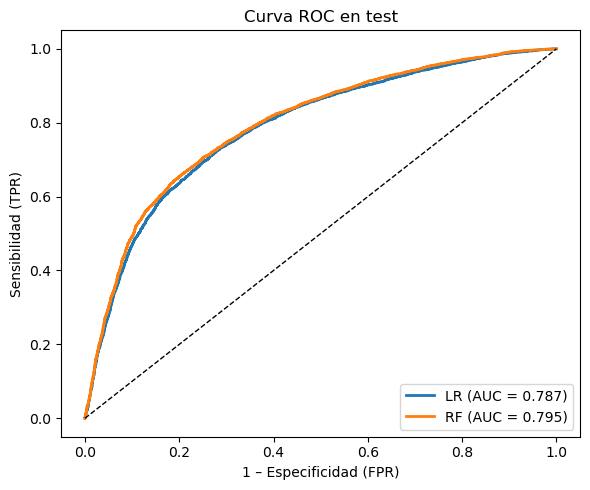

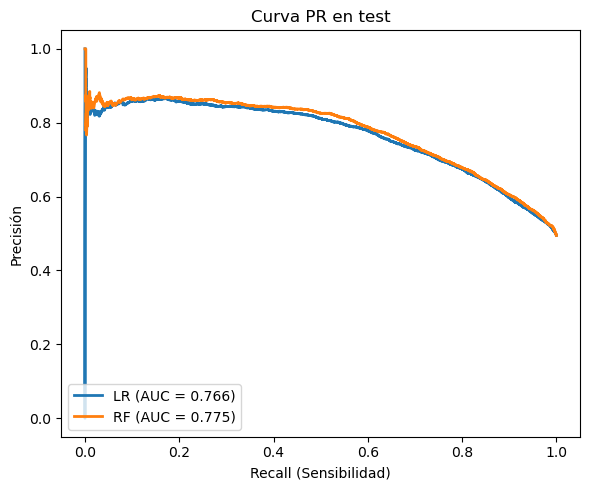

In [17]:
# 6.1 Visualización curvas
# Curvas ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

# Curvas PR
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_pred_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_pred_rf)

# Área bajo curva
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_rf = auc(fpr_rf, tpr_rf)
pr_auc_lr = auc(rec_lr, prec_lr)
pr_auc_rf = auc(rec_rf, prec_rf)

# ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC = {roc_auc_lr:.3f})", lw=2)
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC = {roc_auc_rf:.3f})", lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("1 – Especificidad (FPR)")
plt.ylabel("Sensibilidad (TPR)")
plt.title("Curva ROC en test")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("figures/P2_curva_ROC_test.png", dpi=120)
plt.show()

# PR
plt.figure(figsize=(6, 5))
plt.plot(rec_lr, prec_lr, label=f"LR (AUC = {pr_auc_lr:.3f})", lw=2)
plt.plot(rec_rf, prec_rf, label=f"RF (AUC = {pr_auc_rf:.3f})", lw=2)
plt.xlabel("Recall (Sensibilidad)")
plt.ylabel("Precisión")
plt.title("Curva PR en test")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig("figures/P2_curva_PR_test.png", dpi=120)
plt.show()

**ROC-AUC**

Ambos modelos tienen valores altos (>0.79), lo que indica una buena discriminación. RF supera ligeramente a LR, tanto en CV como en test, pero la diferencia es pequeña.

**PR-AUC**

Aquí, RF también supera ligeramente a LR en PR-AUC, lo que sugiere mejor precisión en los verdaderos positivos.

In [18]:
# 6.2 Bootstrapping para intervalos de ROC-AUC y PR-AUC
# Semilla fija
rng = np.random.default_rng(seed=42)

# Número de iteraciones
n_iterations = 1000

# Arrays para almacenar resultados
roc_lr_scores = []
pr_lr_scores = []
roc_rf_scores = []
pr_rf_scores = []

# Bootstrapping con reemplazo
for _ in range(n_iterations):
    indices = rng.choice(len(y_test), size=len(y_test), replace=True)
    
    # Indexación posicional segura
    y_true_sample = y_test.iloc[indices]
    y_pred_lr_sample = y_pred_lr[indices]
    y_pred_rf_sample = y_pred_rf[indices]
    
    # Métricas
    roc_lr_scores.append(roc_auc_score(y_true_sample, y_pred_lr_sample))
    pr_lr_scores.append(average_precision_score(y_true_sample, y_pred_lr_sample))
    roc_rf_scores.append(roc_auc_score(y_true_sample, y_pred_rf_sample))
    pr_rf_scores.append(average_precision_score(y_true_sample, y_pred_rf_sample))

# Calculo percentiles
def resumen_bootstrap(scores, nombre):
    media = np.mean(scores)
    p2_5 = np.percentile(scores, 2.5)
    p97_5 = np.percentile(scores, 97.5)
    print(f"{nombre}: {media:.3f}  [IC 95%: {p2_5:.3f} – {p97_5:.3f}]")

print("\nRegresión Logística (Test Bootstrapping)")
resumen_bootstrap(roc_lr_scores, "ROC-AUC")
resumen_bootstrap(pr_lr_scores,  "PR-AUC")

print("\nRandom Forest (Test Bootstrapping)")
resumen_bootstrap(roc_rf_scores, "ROC-AUC")
resumen_bootstrap(pr_rf_scores,  "PR-AUC")


Regresión Logística (Test Bootstrapping)
ROC-AUC: 0.787  [IC 95%: 0.779 – 0.795]
PR-AUC: 0.766  [IC 95%: 0.755 – 0.777]

Random Forest (Test Bootstrapping)
ROC-AUC: 0.795  [IC 95%: 0.787 – 0.802]
PR-AUC: 0.776  [IC 95%: 0.764 – 0.787]


El **Test Bootstrapping** muestra que **ambos modelos son estables y robustos**; los intervalos son estrechos, lo que indica una baja variabilidad.

**RF supera ligeramente a LR en ambas métricas**, y se mantiene igual con este test.

PR-AUC ≈ ROC-AUC en ambos casos, lo que confirma que el modelo mantiene precisión en la zona útil clínica (positivos), incluso con balance 50/50.

**Calibración de probabilidades**

Se elige el **método isotonic** para calibrar las probabilidades, dado que el objetivo clínico requiere que las predicciones reflejen con precisión la frecuencia observada del evento cardiovascular. El tamaño del dataset (70,000 observaciones) permite aplicar este método sin riesgo de sobreajuste, y se realizará la calibración mediante validación cruzada para mantener la trazabilidad.

In [20]:
# 7. Calibración de probabilidades
# Antes de calibrar
p_lr_uncal = pipe_lr.predict_proba(X_test)[:, 1]
p_rf_uncal = pipe_rf.predict_proba(X_test)[:, 1]

brier_lr_uncal = brier_score_loss(y_test, p_lr_uncal)
brier_rf_uncal = brier_score_loss(y_test, p_rf_uncal)

print(f"Brier score (LR sin calibrar): {brier_lr_uncal:.3f}")
print(f"Brier score (RF sin calibrar): {brier_rf_uncal:.3f}")

# Calibración con método isotonic en CV
cal_lr = CalibratedClassifierCV(pipe_lr.named_steps['clf'], method='isotonic', cv=5)
cal_rf = CalibratedClassifierCV(pipe_rf.named_steps['clf'], method='isotonic', cv=5)

# Sustituir el clasificador en la pipeline
pipe_lr.named_steps['clf'] = cal_lr
pipe_rf.named_steps['clf'] = cal_rf

# Ajustar sobre X_train
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

# Predicciones calibradas en test
y_prob_lr = pipe_lr.predict_proba(X_test)[:, 1]
y_prob_rf = pipe_rf.predict_proba(X_test)[:, 1]

# Brier scores
brier_lr = brier_score_loss(y_test, y_prob_lr)
brier_rf = brier_score_loss(y_test, y_prob_rf)

print(f"Brier score (LR isotonic): {brier_lr:.3f}")
print(f"Brier score (RF isotonic): {brier_rf:.3f}")

# ROC y PR como discriminación
print(f"ROC-AUC (LR): {roc_auc_score(y_test, y_prob_lr):.3f}")
print(f"PR-AUC  (LR): {average_precision_score(y_test, y_prob_lr):.3f}")
print(f"ROC-AUC (RF): {roc_auc_score(y_test, y_prob_rf):.3f}")
print(f"PR-AUC  (RF): {average_precision_score(y_test, y_prob_rf):.3f}")

Brier score (LR sin calibrar): 0.189
Brier score (RF sin calibrar): 0.184
Brier score (LR isotonic): 0.189
Brier score (RF isotonic): 0.184
ROC-AUC (LR): 0.787
PR-AUC  (LR): 0.766
ROC-AUC (RF): 0.795
PR-AUC  (RF): 0.775


La calibración isotónica no modificó el Brier score en ninguno de los modelos, lo que indica que las probabilidades predichas ya eran fiables antes del ajuste.

In [21]:
# ECE (Expected Calibration Error)
def calc_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_prob, bins) - 1
    ece = 0
    for i in range(n_bins):
        bin_mask = bin_indices == i
        if np.any(bin_mask):
            prob_promedio = np.mean(y_prob[bin_mask])
            fr_eventos = np.mean(y_true[bin_mask])
            ece += np.abs(prob_promedio - fr_eventos) * np.sum(bin_mask) / len(y_true)
    return round(ece, 4)

ece_lr = calc_ece(y_test, y_prob_lr)
ece_rf = calc_ece(y_test, y_prob_rf)

print(f"ECE Regresión Logística calibrada: {ece_lr}")
print(f"ECE Random Forest calibrado: {ece_rf}")

ECE Regresión Logística calibrada: 0.0296
ECE Random Forest calibrado: 0.0127


La RL está	muy bien calibrada globalmente, pero con ligeras desviaciones locales en algunos bins, mientras que RF muestra una excelente calibración local; las probabilidades predichas reflejan muy bien el riesgo.

Ambos valores son muy bajos (por debajo de 0.03), lo que indica que **la calibración isotónica ha sido efectiva**. El **RF** muestra una **calibración aún más ajustada que la RL**, en términos de ECE.

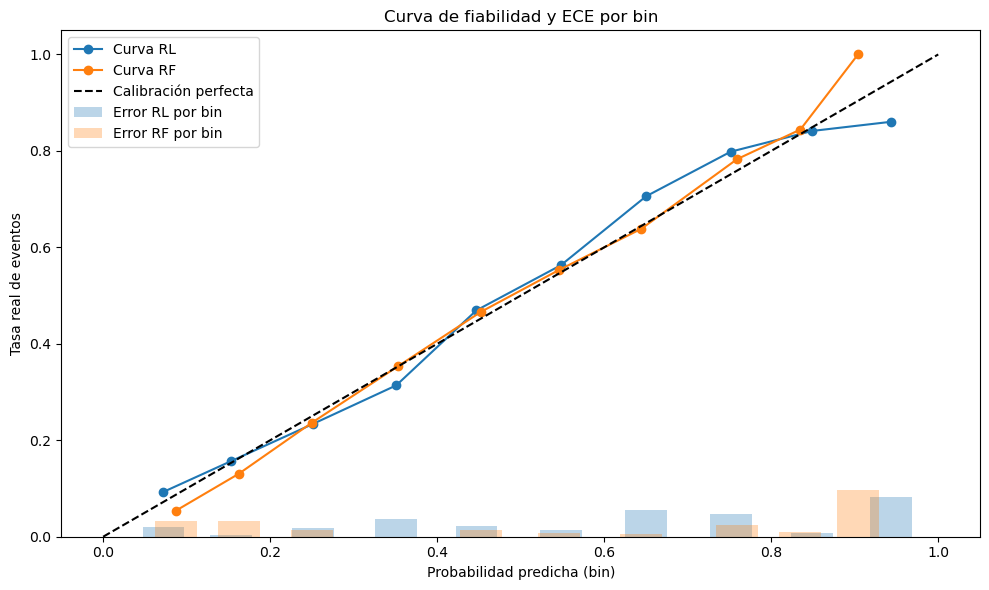

In [22]:
# 7.2 Curva de fiabilidad
def calibration_stats(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_prob, bins) - 1
    prob_pred, prob_true, ece_bin = [], [], []
    for i in range(n_bins):
        mask = bin_indices == i
        if np.any(mask):
            p_pred = np.mean(y_prob[mask])
            p_true = np.mean(y_true[mask])
            prob_pred.append(p_pred)
            prob_true.append(p_true)
            ece_bin.append(abs(p_pred - p_true))
    return np.array(prob_pred), np.array(prob_true), np.array(ece_bin)

lr_pred, lr_true, lr_ece = calibration_stats(y_test, y_prob_lr)
rf_pred, rf_true, rf_ece = calibration_stats(y_test, y_prob_rf)


plt.figure(figsize=(10,6))
plt.plot(lr_pred, lr_true, marker='o', label='Curva RL', color='tab:blue')
plt.plot(rf_pred, rf_true, marker='o', label='Curva RF', color='tab:orange')
plt.plot([0,1], [0,1], 'k--', label='Calibración perfecta')

plt.bar(lr_pred, lr_ece, width=0.05, alpha=0.3, color='tab:blue', label='Error RL por bin')
plt.bar(rf_pred, rf_ece, width=0.05, alpha=0.3, color='tab:orange', label='Error RF por bin')

plt.xlabel('Probabilidad predicha (bin)')
plt.ylabel('Tasa real de eventos')
plt.title('Curva de fiabilidad y ECE por bin')
plt.legend()
plt.tight_layout()
plt.savefig("figures/P2_curva_fiabilidad_ECE.png", dpi=120)
plt.show()

La RL sigue bastante bien la diagonal, pero con ligeras desviaciones en bins intermedios. Las barras de ECE por bin muestran **errores locales moderados, especialmente en probabilidades entre 0.4 y 0.7**.

El RF está más pegado a la diagonal, con menor dispersión. Las barras de ECE son más bajas y uniformes, lo que indica calibración más estable en todos los rangos.

Ambos modelos están bien calibrados, pero el **RF ofrece probabilidades más fiables en todos los rangos**, lo que es crucial a la hora de tomar decisiones clínicas basadas en umbrales.

La curva de fiabilidad y las barras de ECE justifican que **el modelo RF no solo tiene un buen Brier, sino que no sobreestima ni subestima el riesgo en ningún bin**.

In [23]:
# 8. Selección de umbral operativo
# Umbrales
def youden_thr(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    J = tpr - fpr
    return thresholds[np.argmax(J)]

def coste_thr(y_true, y_prob, ratio=5):
    grid = np.linspace(0.01, 0.99, 99)
    def coste(th):
        pred = (y_prob >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
        return fp + fn * ratio
    return grid[np.argmin([coste(t) for t in grid])]

def topk_thr(y_true, y_prob, k=0.2):
    n = int(k * len(y_prob))
    return np.partition(y_prob, -n)[-n]

criterios = {"Youden J": youden_thr,
             "Coste 5:1": coste_thr,
             "Top-k": topk_thr}

# Evaluación de cada modelo
def evaluar_umbral(y_true, y_prob):
    resultados = []
    for criterio, func in criterios.items():
        thr = func(y_true, y_prob)
        y_pred = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sens = tp / (tp + fn + 1e-12)
        espec = tn / (tn + fp + 1e-12)
        ppv = tp / (tp + fp + 1e-12)
        npv = tn / (tn + fn + 1e-12)
        f1 = 2 * tp / (2 * tp + fp + fn + 1e-12)
        resultados.append([criterio, thr, sens, espec, ppv, npv, f1])
    return resultados

res_lr = evaluar_umbral(y_test, y_prob_lr)
res_rf = evaluar_umbral(y_test, y_prob_rf)

cols = ["Criterio", "Umbral", "Sens", "Espec", "PPV", "NPV", "F1"]
df_rl = pd.DataFrame(res_lr, columns=cols)
df_rf = pd.DataFrame(res_rf, columns=cols)

for col in df_rl.columns[1:]:
    df_rl[col] = df_rl[col].map(lambda x: f"{x:.3f}")

for col in df_rf.columns[1:]:
    df_rf[col] = df_rf[col].map(lambda x: f"{x:.3f}")

# Tabla
def format_taula(df_model, title):
    best_f1 = df_model["F1"].astype(float).max()

    def destacar_mejor(row):
        color = "#e6ffe6" if float(row["F1"]) == best_f1 else ""
        return ["background-color: " + color] * len(row)

    return (
        df_model.style
        .hide(axis="index")
        .set_caption(title)
        .set_table_styles([
            {"selector": "caption", "props": [("font-size", "16px"), ("font-weight", "bold"), ("text-align", "left")]},
            {"selector": "th", "props": [("background-color", "#f2f2f2"), ("font-weight", "bold")]}
        ])
        .apply(destacar_mejor, axis=1))

display(format_taula(df_rl, "Regresión Logística calibrada — Comparativa de criterios de umbral"))
display(format_taula(df_rf, "Random Forest calibrado — Comparativa de criterios de umbral"))

Criterio,Umbral,Sens,Espec,PPV,NPV,F1
Youden J,0.477,0.693,0.752,0.732,0.714,0.712
Coste 5:1,0.150,0.986,0.114,0.521,0.893,0.682
Top-k,0.751,0.341,0.938,0.843,0.592,0.485


Criterio,Umbral,Sens,Espec,PPV,NPV,F1
Youden J,0.466,0.707,0.748,0.733,0.723,0.720
Coste 5:1,0.170,0.989,0.110,0.521,0.912,0.683
Top-k,0.806,0.342,0.940,0.847,0.593,0.488


En LR, el criterio Youden J es el que muestra mejor equilibrio; el Coste 5:1 es bueno para la detección masiva (screening) y; el Top-k serviria para priorizar casos de alto riesgo (como  una segmentación).

En RF se observan que todos los umbrales son ligeramente mejores en todas las métricas comparables.
Por tanto, si no hay un coste muy alto para FP, el **RF + Youden J es el mejor umbral operativo**.

,Umbral,Beneficio RL,Beneficio RF,Tratar a todos,Tratar a ninguno
0,0.01,-0.011,-0.011,0.005,0
1,0.02,-0.011,-0.011,0.010,0
2,0.03,-0.011,-0.011,0.015,0
3,0.04,-0.010,-0.011,0.020,0
4,0.05,-0.007,-0.011,0.025,0


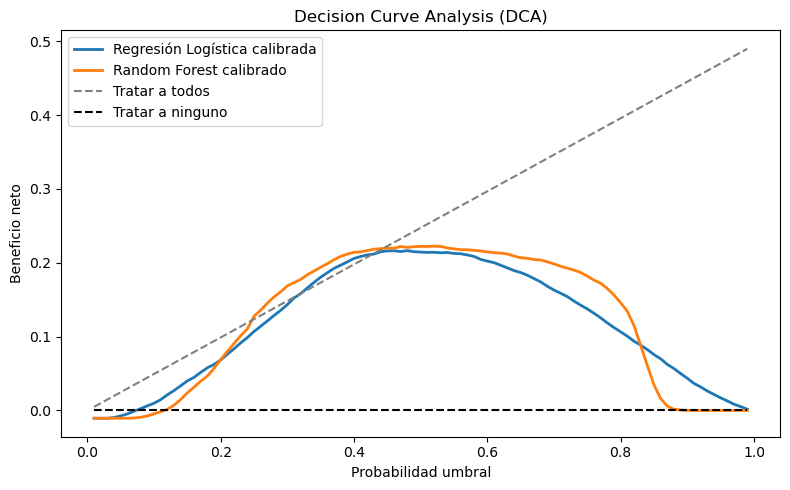

In [24]:
# 8.1 DCA para ambos modelos
umbral_grid = np.linspace(0.01, 0.99, 99)

def beneficio_neto(y_true, y_prob, thr, ratio_fp=1, ratio_fn=1):
    pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    n = len(y_true)
    return (tp / n) - (fp / n) * (ratio_fp / ratio_fn)

def calcular_dca(y_true, y_prob, ratio_fp=1, ratio_fn=1):
    return [(thr, beneficio_neto(y_true, y_prob, thr, ratio_fp, ratio_fn)) for thr in umbral_grid]

dca_rl = calcular_dca(y_test, y_prob_lr)
dca_rf = calcular_dca(y_test, y_prob_rf)

# Convertir a DataFrame para visualitzación
df_dca_rl = pd.DataFrame(dca_rl, columns=["Umbral", "Beneficio RL"])
df_dca_rf = pd.DataFrame(dca_rf, columns=["Umbral", "Beneficio RF"])

df_dca = df_dca_rl.merge(df_dca_rf, on="Umbral")

df_dca["Tratar a todos"] = df_dca["Umbral"] * (y_test.mean())  # aproximació simple
df_dca["Tratar a ninguno"] = 0

# Primeras 5 filas
display(df_dca.round(3).head(5))

# Visualitzación
plt.figure(figsize=(8,5))
plt.plot(df_dca["Umbral"], df_dca["Beneficio RL"], label="Regresión Logística calibrada", lw=2)
plt.plot(df_dca["Umbral"], df_dca["Beneficio RF"], label="Random Forest calibrado", lw=2)
plt.plot(df_dca["Umbral"], df_dca["Tratar a todos"], "--", label="Tratar a todos", color="gray")
plt.plot(df_dca["Umbral"], df_dca["Tratar a ninguno"], "--", label="Tratar a ninguno", color="black")

plt.xlabel("Probabilidad umbral")
plt.ylabel("Beneficio neto")
plt.title("Decision Curve Analysis (DCA)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/P2_DCA.png", dpi=120)
plt.show()

Tanto la RL como el RF tienen una forma curvada que sube y después baja (normal).

**Los dos modelos aportan beneficios entre lindares aproximadamente de 0.2 a 0.6**, es decir, si el criterio de decisión está dentro de este rango, usar el modelo es mejor que tratar a todos o a ninguno.

El RF tiene ligeramente más beneficio en la mayoría de los puntos, cosa que indica que es ligeramente más útil clínicamente.

In [25]:
# 9. Interpretabilidad (PI, PDP/ALE)
# 9.1 Permutation Importance (PI)
sc_pr = make_scorer(average_precision_score)

# Importancia permutada con PR-AUC sobre rf (evita el meta‑estimador calibrado para PI)
pimp = permutation_importance(pipe_rf, X_test, y_test, scoring=sc_pr, n_repeats=10, random_state=42)
imp = (pd.DataFrame({'feature': X.columns, 'importance_mean': pimp.importances_mean,
                     'importance_std': pimp.importances_std})
         .sort_values('importance_mean', ascending=False))
print(imp.head(10))

        feature  importance_mean  importance_std
4         ap_hi         0.115507        0.001228
6   cholesterol         0.040506        0.002627
0     age_years         0.012398        0.001543
5         ap_lo         0.004717        0.001292
11       active         0.001945        0.000726
7          gluc         0.001589        0.000433
10         alco         0.000557        0.000177
8        gender         0.000245        0.000380
9         smoke         0.000209        0.000408
1        height         0.000031        0.000772


La variable más importante es la **presión sistólica** relevante en hipertensión. Seguido del ***cholesterol***, que tiene un impacto directo en riesgo cardiovascular.Y la ***age_years*** que también es un factor de riesgo importante. Ya con menos importancia aparece ***ap_lo*** y la ***active***.

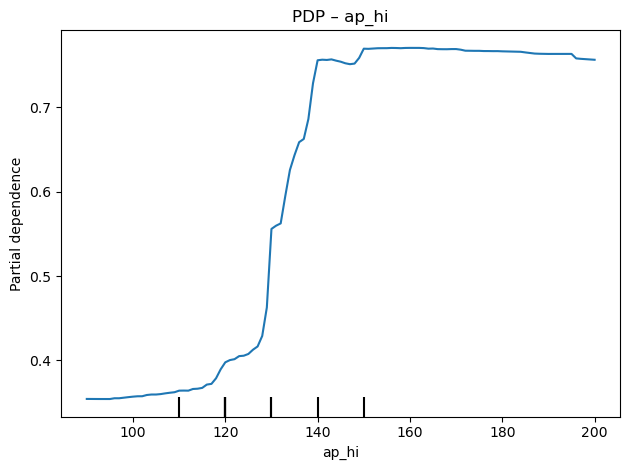

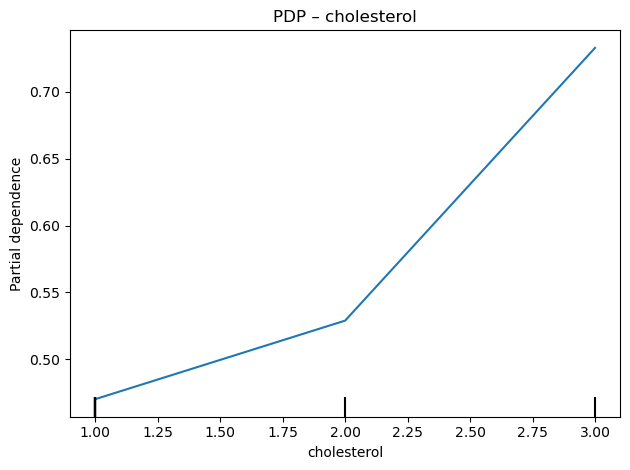

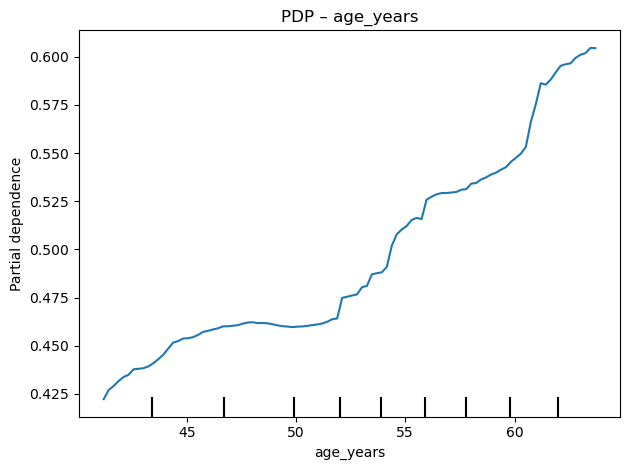

In [26]:
# 9.2 PDP
# Filtrar las primeras 3 variables numéricas del ranking PI
top = ['ap_hi', 'cholesterol', 'age_years']

# Crear copia con conversión explícita a float
X_float = X.copy()
for f in top:
    X_float[f] = X_float[f].astype(float)

# Graficar PDP solo para variables numéricas válidas
for f in top:
    try:
        PartialDependenceDisplay.from_estimator(pipe_rf, X_float, [f])
        plt.title(f'PDP – {f}')
        plt.tight_layout()
        plt.savefig(f"figures/P2_PDP_{f}.png", dpi=120)
        plt.show()
    except Exception as e:
        print('PDP falló en', f, e, '→ Si hay fuerte correlación, considera ALE.')

En estas curvas PDP vemos como la ***ap_hi*** muestra que el riesgo aumenta muchísimo entre 130 - 140 mmHg, donde indica claramente que los pacientes tiene prehipertensión y por tanto, mayor riesgo cv. El ***cholesterol*** muestra un cambio importante al pasar del valor normal (1) a por encima de lo normal (2) donde el riesgo se ve aumentado. Y la ***age_years*** vemos una curva en aumento, lo que es lógico, a mayor edad mayor riesgo cv.

In [27]:
# 9.3 Correlación
# Umbral de correlación
thr = 0.7

# Seleccionar solo columnas numéricas
X_num = X_train.select_dtypes(include="number")

# Matriz de correlación absoluta
corr = X_num.corr().abs()

# Detectar variables con correlación > 0.7 con al menos otra
correladas = [col for col in X_num.columns if any(corr[col].drop(col) > thr)]

# Filtrar solo las variables clínicas clave que cumplen correlación
vbles_cli = ['BMI', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'age_ years', 'active']
ale_vars = [v for v in vbles_cli if v in correladas]

print("\nVariables clínicas con correlación significativa (usables en ALE):")
print(ale_vars)


Variables clínicas con correlación significativa (usables en ALE):
['BMI', 'ap_hi', 'ap_lo']


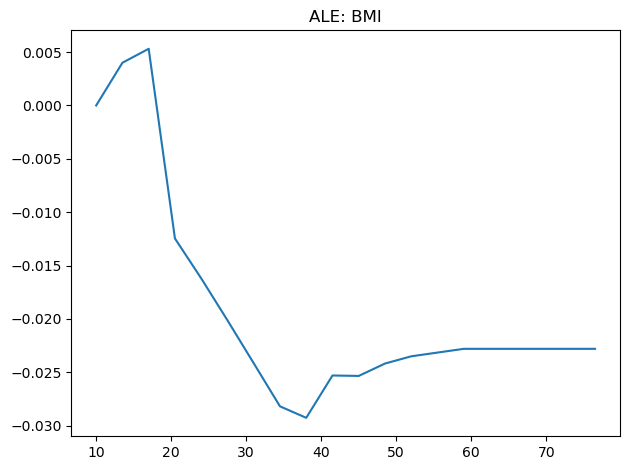

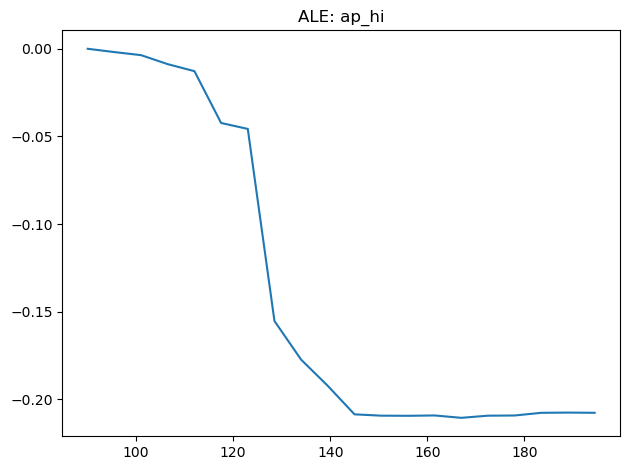

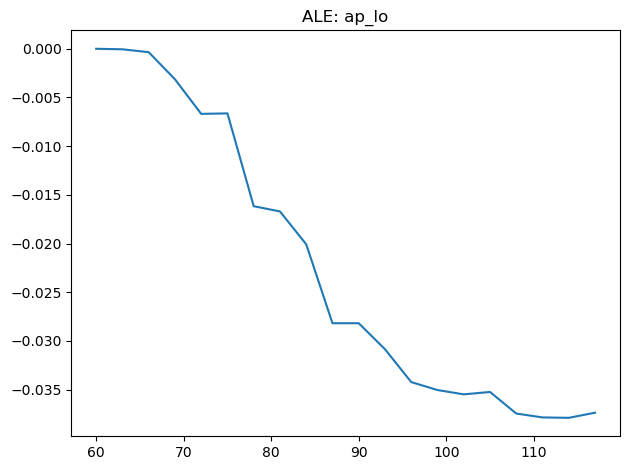

In [28]:
# 9.4 ALE
def ale (pipe_rf, X, feature, bins=20):
    x = X[feature].values
    bin_edges = np.linspace(x.min(), x.max(), bins+1)
    ale_values = []
    for i in range(bins):
        mask = (x >= bin_edges[i]) & (x < bin_edges[i+1])
        if mask.sum() == 0:
            ale_values.append(0)
            continue
        preds = pipe_rf.predict_proba(X)[:,1]
        X_temp = X.copy()
        X_temp[feature] = bin_edges[i]
        preds_new = pipe_rf.predict_proba(X_temp)[:,1]
        ale_values.append((preds_new[mask] - preds[mask]).mean())
    return bin_edges[:-1], np.cumsum(ale_values)

for var in ale_vars:
    if X_train[var].nunique() < 5:
        print(f"Variable {var} tiene pocos valores únicos, se omite.")
        continue
    bin_centers, ale_vals = ale(pipe_rf, X_train, var)
    plt.plot(bin_centers, ale_vals)
    plt.title(f"ALE: {var}")
    plt.tight_layout()
    plt.savefig(f"figures/P2_ALE_{var}.png", dpi=120)
    plt.show()

En **ALE_BMI** la curva muestra que cuando el *BMI* es bajo (10–20 Kg/m<sup>2</sup>), el efecto acumulado sobre la predicción es positivo; el modelo asocia bajo peso con mayor riesgo clínico. A partir de *BMI* ≈ 25 Kg/m<sup>2</sup>, el efecto se vuelve negativo y cae bruscamente hasta *BMI* ≈ 40 Kg/m<sup>2</sup>, lo que indica que el modelo asocia sobrepeso y obesidad con menor riesgo. Desde *BMI* > 60 Kg/m<sup>2</sup>, el efecto se estabiliza en valores negativos, sin más descenso.

El modelo está captando que **bajo peso se asocia con eventos clínicos**, posiblemente por fragilidad, edad avanzada o comorbilidades. El descenso entre 25–40 podría reflejar un sesgo del dataset: si los pacientes con obesidad están más controlados o medicados, el modelo puede aprender que tienen menor riesgo observado. El efecto plano en *BMI* > 60 Kg/m<sup>2</sup> indica que el modelo no distingue más allá de ese punto, debido a la baja n que hay en este rango.

En **ALE_ap_hi** la curva muestra una caída progresiva del efecto acumulado a medida que ap_hi aumenta; esto indica que el modelo se asocia a una **presión sistólica alta con mayor riesgo clínico**, lo cual es coherente con guías médicas. El descenso se acentúa entre 130 y 140 mmHg, lo que coincide con el umbral clínico de hipertensión grado 1. El modelo está captando este corte funcional, lo que valida su sensibilidad en patrones médicos reales.

En **ALE_ap_lo** la curva muestra que a medida que la presión diastólica aumenta (de 60 a 115 mmHg), el efecto acumulado sobre la predicción disminuye. Esto indica que el modelo asocia **presión diastólica alta con menor riesgo clínico**, lo cual puede parecer contraintuitivo si no está ajustado por edad o comorbilidad; esto puede reflejar casos de hipotensión o disfunción cardiovascular avanzada, especialmente en pacientes frágiles o ancianos. El descenso progresivo sugiere que el modelo no está captando un umbral clínico claro, sino una relación continua.

Debido a los resultado del ALE, se considera mirar la interacción entre presión sistólica y BMI y la interacción entre presión sistólica y edad (en años) y la interacción entre presión diastólica y edad (en años) para ver si el impacto varía.

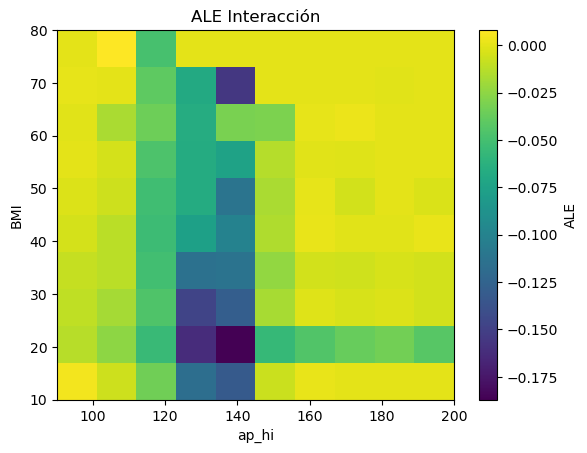

In [29]:
# 9.5 Interacción entre variables
# 9.5.1 Interacción entre BMI y ap_hi
feature1, feature2 = 'BMI', 'ap_hi'
bins = 10

x1_edges = np.linspace(X_train[feature1].min(), X_train[feature1].max(), bins+1)
x2_edges = np.linspace(X_train[feature2].min(), X_train[feature2].max(), bins+1)

ale_matrix = np.zeros((bins, bins))

for i in range(bins):
    for j in range(bins):
        mask = (X_train[feature1] >= x1_edges[i]) & (X_train[feature1] < x1_edges[i+1]) & \
               (X_train[feature2] >= x2_edges[j]) & (X_train[feature2] < x2_edges[j+1])
        if mask.sum() == 0:
            continue
        
        preds = pipe_rf.predict_proba(X_train)[:,1]
        X_temp = X_train.copy()
        X_temp[feature1] = x1_edges[i]
        X_temp[feature2] = x2_edges[j]
        preds_new = pipe_rf.predict_proba(X_temp)[:,1]
        
        ale_matrix[i,j] = (preds_new[mask] - preds[mask]).mean()

plt.imshow(ale_matrix, origin='lower', aspect='auto',
           extent=[x2_edges[0], x2_edges[-1], x1_edges[0], x1_edges[-1]])
plt.xlabel(feature2)
plt.ylabel(feature1)
plt.title('ALE Interacción')
plt.colorbar(label='ALE')
plt.savefig("figures/P2_ALE_interac_BMI_aphi.png", dpi=120)
plt.show()

En pacientes con ***BMI*** **alto (≥35 Kg/m<sup>2</sup>)** y ***ap_hi*** **elevado (≥140 mmHg)**, el modelo predice un **mayor riesgo**; esto es clínicamente coherente: obesidad + hipertensión = alto riesgo cardiovascular.

En pacientes con ***BMI*** **bajo (<20 Kg/m<sup>2</sup>)** y ***ap_hi*** **normal (<120 mmHg)**, el modelo también predice **riesgo elevado**; podría reflejar fragilidad o comorbilidad en pacientes delgados.

En el rango medio (***BMI*** **25–30 Kg/m<sup>2</sup>)** y ***ap_hi*** **120–130 mmHg**), el modelo predice **menor riesgo**, lo que sugiere que considera ese perfil como metabólicamente estable, según clínica.

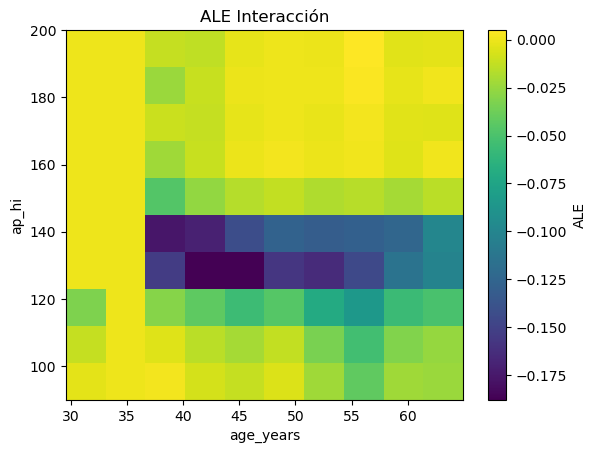

In [30]:
# 9.5.2 Interacción entre ap_hi y age_years
feature1, feature2 = 'ap_hi', 'age_years'
bins = 10

x1_edges = np.linspace(X_train[feature1].min(), X_train[feature1].max(), bins+1)
x2_edges = np.linspace(X_train[feature2].min(), X_train[feature2].max(), bins+1)

ale_matrix = np.zeros((bins, bins))

for i in range(bins):
    for j in range(bins):
        mask = (X_train[feature1] >= x1_edges[i]) & (X_train[feature1] < x1_edges[i+1]) & \
               (X_train[feature2] >= x2_edges[j]) & (X_train[feature2] < x2_edges[j+1])
        if mask.sum() == 0:
            continue
        
        preds = pipe_rf.predict_proba(X_train)[:,1]
        X_temp = X_train.copy()
        X_temp[feature1] = x1_edges[i]
        X_temp[feature2] = x2_edges[j]
        preds_new = pipe_rf.predict_proba(X_temp)[:,1]
        
        ale_matrix[i,j] = (preds_new[mask] - preds[mask]).mean()

plt.imshow(ale_matrix, origin='lower', aspect='auto',
           extent=[x2_edges[0], x2_edges[-1], x1_edges[0], x1_edges[-1]])
plt.xlabel(feature2)
plt.ylabel(feature1)
plt.title('ALE Interacción')
plt.colorbar(label='ALE')
plt.savefig("figures/P2_ALE_interac_aphi_age_years.png", dpi=120)
plt.show()

En el eje X (*age_years*) se observa que a medida que la edad aumenta, el riesgo predicho por el modelo también lo hace, especialmente en combinación con presión alta. En el eje Y (*ap_hi*) los valores altos (≥ 140 mmHg) se asocian con un mayor riesgo, pero este efecto se intensifica en pacientes mayores.

En las zonas oscuras (ALE negativo) se indican combinaciones donde el modelo predice mayor probabilidad de evento clínico. Por ejemplo:

* Edad > 60 años + *ap_hi* > 140 mmHg → riesgo amplificado
* Edad < 40 años + *ap_hi* normal → riesgo bajo

Se puede observar como el modelo no trata ***age_years*** y ***ap_hi*** como independientes, sino que detecta **efectos sinérgicos**. Esto valida que el modelo está captando patrones clínicos reales, como el **impacto de la hipertensión en adultos mayores**.

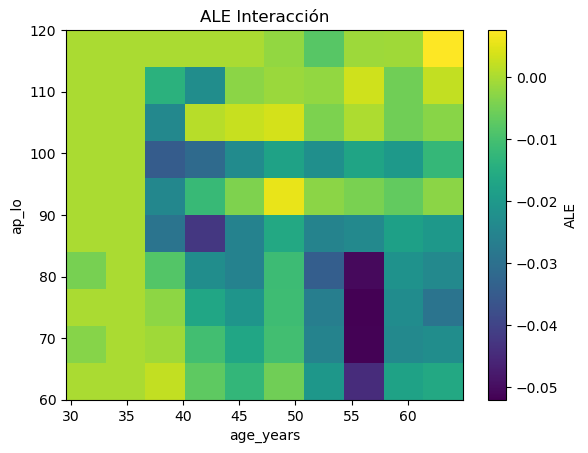

In [31]:
# 9.5.3 Interacción entre ap_lo y age_years
feature1, feature2 = 'ap_lo', 'age_years'
bins = 10

x1_edges = np.linspace(X_train[feature1].min(), X_train[feature1].max(), bins+1)
x2_edges = np.linspace(X_train[feature2].min(), X_train[feature2].max(), bins+1)

ale_matrix = np.zeros((bins, bins))

for i in range(bins):
    for j in range(bins):
        mask = (X_train[feature1] >= x1_edges[i]) & (X_train[feature1] < x1_edges[i+1]) & \
               (X_train[feature2] >= x2_edges[j]) & (X_train[feature2] < x2_edges[j+1])
        if mask.sum() == 0:
            continue
        
        preds = pipe_rf.predict_proba(X_train)[:,1]
        X_temp = X_train.copy()
        X_temp[feature1] = x1_edges[i]
        X_temp[feature2] = x2_edges[j]
        preds_new = pipe_rf.predict_proba(X_temp)[:,1]
        
        ale_matrix[i,j] = (preds_new[mask] - preds[mask]).mean()

plt.imshow(ale_matrix, origin='lower', aspect='auto',
           extent=[x2_edges[0], x2_edges[-1], x1_edges[0], x1_edges[-1]])
plt.xlabel(feature2)
plt.ylabel(feature1)
plt.title('ALE Interacción')
plt.colorbar(label='ALE')
plt.savefig("figures/P2_ALE_interac_aplo_age_years.png", dpi=120)
plt.show()

La **edad avanzada (>60 años)** combinada con ***ap_lo*** **baja (<70 mmHg)** genera los valores más negativos de ALE. Esto es coherente con **perfiles clínicos de fragilidad cardiovascular**, donde la hipotensión puede reflejar disfunción hemodinámica o comorbilidad. En pacientes jóvenes (<40 años), el impacto de *ap_lo* es mucho menor, lo que sugiere que el modelo modula el riesgo según contexto fisiológico.

Por tanto, aquí el modelo también no trata *age_years* y *ap_lo* como independientes, sino que detecta **efectos sinérgicos**. No hay ningún umbral clínico abrupto, sino una gradiente continua de riesgo amplificado por la interacción. Esto valida que el modelo está captando patrones clínicos reales, pero también exige revisión de calibración en zonas críticas.

In [32]:
# 10. Subgrupos y equidad
# Probabilidades calibradas
y_score = pipe_rf.predict_proba(X_test)[:, 1]

# Umbral óptimo (Youden)
thr = youden_thr(y_test, y_score)
print("\nUmbral elegido:")
print("Youden: ", thr.round(3))

# Predicción binaria con umbral elegido
y_pred = (y_score >= thr).astype(int)

# Reconstruir df_eval con trazabilidad desde df original
flags = ['flag_HTA', 'flag_riesgo_clinico', 'flag_riesgo_estilo_vida']
df_eval = df.loc[X_test.index, ['gender', 'age_band'] + num_cols + flags].copy()
df_eval['y_true'] = y_test
df_eval['y_score'] = y_score
df_eval['y_pred'] = y_pred

# Función para métricas por subgrupo
def compute_metrics(group_df):
    tn, fp, fn, tp = confusion_matrix(group_df['y_true'], group_df['y_pred'], labels=[0,1]).ravel()
    sens = tp / (tp + fn + 1e-12)
    spec = tn / (tn + fp + 1e-12)
    ppv  = tp / (tp + fp + 1e-12)
    npv  = tn / (tn + fn + 1e-12)
    rate = group_df['y_pred'].mean()
    return pd.Series({'Sens': round(sens, 3), 'Spec': round(spec, 3), 
                      'PPV': round(ppv, 3), 'NPV': round(npv, 3), 'Tasa positivos': round(rate, 3)})

# Evaluar por sexo
by_gender = []
for name, group in df_eval.groupby('gender', observed=True):
    metrics = compute_metrics(group)
    metrics['gender'] = name
    by_gender.append(metrics)
by_gender = pd.DataFrame(by_gender).set_index('gender').round(3)
by_gender.index = by_gender.index.astype(int).map({1: 'Mujer', 2: 'Hombre'})

print("\nMétricas por sexo:")
display(by_gender)

# Evaluar por banda de edad
by_age = []
for name, group in df_eval.groupby('age_band', observed=True):
    metrics = compute_metrics(group)
    metrics['age_band'] = name
    by_age.append(metrics)
by_age = pd.DataFrame(by_age).set_index('age_band').round(3)

print("\nMétricas por banda de edad:")
display(by_age)

# Evaluar por flags clínicas
for flag in flags:
    print(f"\nMétricas por subgrupo: {flag}")
    by_flag = []
    for name, group in df_eval.groupby(flag, observed=True):
        metrics = compute_metrics(group)
        metrics[flag] = name
        by_flag.append(metrics)
    by_flag = pd.DataFrame(by_flag).set_index(flag).round(3)
    display(by_flag)


Umbral elegido:
Youden:  0.466

Métricas por sexo:


,Sens,Spec,PPV,NPV,Tasa positivos
gender,,,,,
Mujer,0.707,0.750,0.736,0.722,0.477
Hombre,0.707,0.745,0.729,0.724,0.477



Métricas por banda de edad:


,Sens,Spec,PPV,NPV,Tasa positivos
age_band,,,,,
"[0,40)",0.474,0.935,0.673,0.863,0.155
"[40,50)",0.605,0.890,0.764,0.794,0.293
"[50,60)",0.674,0.728,0.724,0.679,0.479
"[60,70)",0.867,0.375,0.733,0.587,0.786



Métricas por subgrupo: flag_HTA


,Sens,Spec,PPV,NPV,Tasa positivos
flag_HTA,,,,,
0.0,0.155,0.965,0.607,0.767,0.066
1.0,0.766,0.667,0.737,0.701,0.571



Métricas por subgrupo: flag_riesgo_clinico


,Sens,Spec,PPV,NPV,Tasa positivos
flag_riesgo_clinico,,,,,
0.0,0.211,0.937,0.587,0.739,0.107
1.0,0.887,0.440,0.749,0.673,0.773



Métricas por subgrupo: flag_riesgo_estilo_vida


,Sens,Spec,PPV,NPV,Tasa positivos
flag_riesgo_estilo_vida,,,,,
0.0,0.694,0.761,0.734,0.723,0.460
1.0,0.738,0.714,0.731,0.721,0.518


El modelo calibrado muestra **equidad por sexo**, con métricas casi idénticas entre hombres y mujeres. Sin embargo, se observa **variabilidad por edad**: mayor sensibilidad en adultos mayores pero menor especificidad, y lo contrario en jóvenes. Esto puede reflejar diferencias reales en prevalencia o sesgo en la calibración del modelo.

Hay un sesgo por edad y riesgo clínico donde hay más positivos en mayores y en pacientes con HTA o riesgo alto. Además de una alta sensibilidad en grupos clínicamente relevantes, pero con pérdida de especificidad.

Esto sugiere que el modelo prioriza detección en pacientes de alto riesgo, lo cual puede ser deseable para una intervención temprana, pero requiere de validación clínica para evitar sobretratamiento.

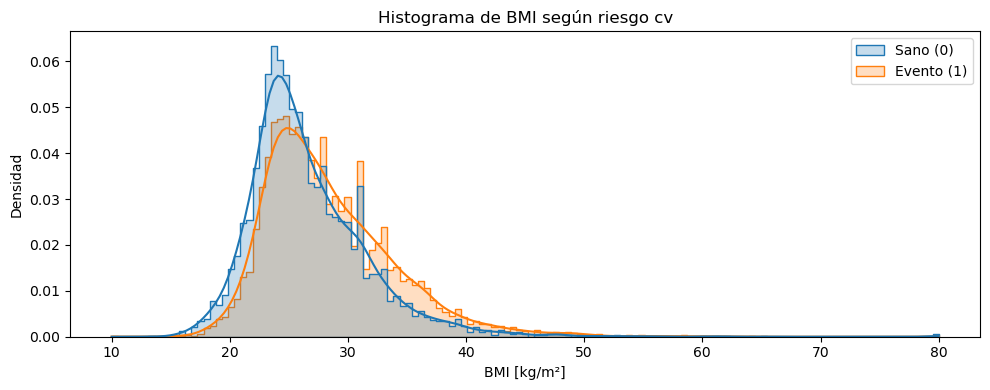

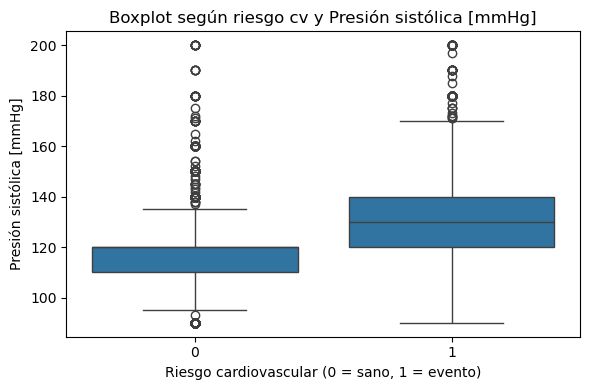

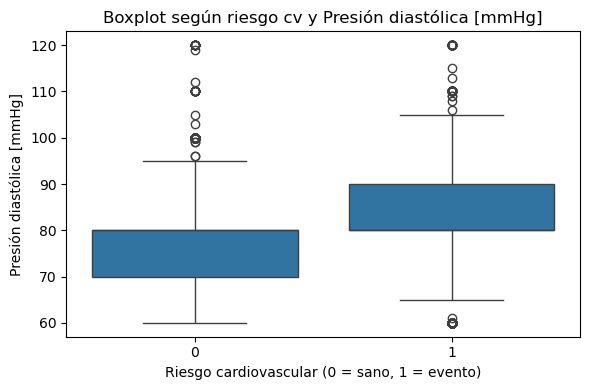

In [33]:
# 11. Visualización útil 
# 11.1 Histogramas y boxplots por clase
# Histograma de BMI
plt.figure(figsize=(10, 4))
plot = sns.histplot(data=df_eval, x='BMI', hue='y_true', kde=True, element='step', stat='density')

legend = plot.legend_
if legend:
    legend.set_title(None)  # Eliminar encabezado
    for text, new_label in zip(legend.texts, ['Sano (0)', 'Evento (1)']):
        text.set_text(new_label)

plt.xlabel('BMI [kg/m²]')
plt.ylabel('Densidad')
plt.title('Histograma de BMI según riesgo cv')
plt.tight_layout()
plt.savefig('figures/P2_hist_riesgo_BMI.png', dpi=120)
plt.show()

# Boxplots por clase para ap_hi y ap_lo
vars_box = {'ap_hi': 'Presión sistólica [mmHg]', 'ap_lo': 'Presión diastólica [mmHg]'}

for var, label in vars_box.items():
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_eval, x='y_true', y=var)
    plt.xlabel('Riesgo cardiovascular (0 = sano, 1 = evento)')
    plt.ylabel(label)
    plt.title(f'Boxplot según riesgo cv y {label}')
    plt.tight_layout()
    plt.savefig(f'figures/P2_box_riesgo_{label}.png', dpi=120)
    plt.show()

El **histograma del** ***BMI*** según riesgo cardiovascular muestra que la curva de pacientes sanos tiene su pico en valores más bajos de *BMI* (≈22–24 Kg/m<sup>2</sup>). La curva de pacientes con riesgo cv está desplazada hacia la derecha, con mayor densidad en *BMI* altos (≈26–30 Kg/m<sup>2</sup>). Todo esto sugiere que el modelo detecta una **asociación positiva entre *BMI* elevado y riesgo cardiovascular**, coherente con evidencia clínica.

El **boxplot de la presión sistólica** muestra que los pacientes con evento tienen una mediana sistólica más alta y mayor dispersión. Aparecen más outliers hipertensivos en el grupo con riesgo, por tanto, esto valida que **el modelo está captando correctamente la hipertensión como factor de riesgo**.

El **boxplot de la presión diastólica** muestra que aunque la diferencia es menos marcada que en la sistólica, **los pacientes con riesgo cv tienden a tener valores diastólicos más altos**. También hay más outliers en el grupo de evento, lo que sugiere variabilidad hemodinámica.

En conclusión, las tres gráficas confirman que el modelo está captando patrones fisiológicos reales:

* *BMI* elevado → mayor riesgo.
* Presión arterial alta → mayor riesgo.
* Distribuciones coherentes con la literatura clínica.

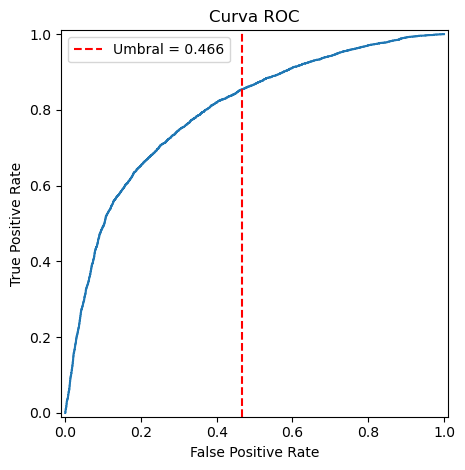

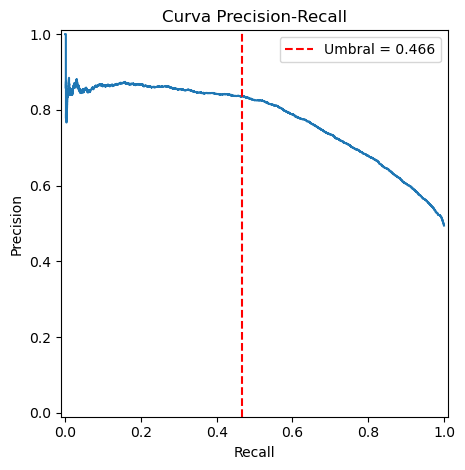

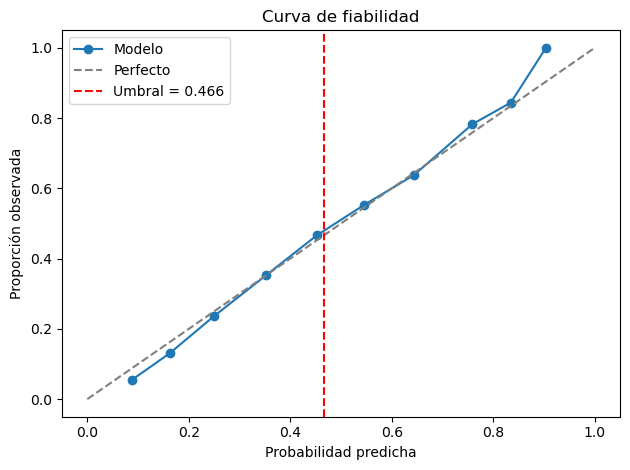

In [34]:
# 11.2 Curvas ROC, PR y fiabilidad
# ROC
fpr, tpr, _ = roc_curve(df_eval['y_true'], df_eval['y_score'])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title('Curva ROC')
plt.axvline(x=thr, color='red', linestyle='--', label=f'Umbral = {thr:.3f}')
plt.legend()
plt.tight_layout()
plt.savefig('figures/P2_ROC_youden.png', dpi=120)
plt.show()

# PR
prec, rec, _ = precision_recall_curve(df_eval['y_true'], df_eval['y_score'])
PrecisionRecallDisplay(precision=prec, recall=rec).plot()
plt.title('Curva Precision-Recall')
plt.axvline(x=thr, color='red', linestyle='--', label=f'Umbral = {thr:.3f}')
plt.legend()
plt.tight_layout()
plt.savefig('figures/P2_PR_youden.png', dpi=120)
plt.show()

# Fiabilidad (calibration)
prob_true, prob_pred = calibration_curve(df_eval['y_true'], df_eval['y_score'], n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Modelo')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfecto')
plt.xlabel('Probabilidad predicha')
plt.ylabel('Proporción observada')
plt.title('Curva de fiabilidad')
plt.axvline(x=thr, color='red', linestyle='--', label=f'Umbral = {thr:.3f}')
plt.legend()
plt.tight_layout()
plt.savefig('figures/P2_calibration_youden.png', dpi=120)
plt.show()

La **curva ROC** muestra una **buena capacidad discriminativa**. El umbral elegido busca maximizar sensibilidad + especificidad, pero no necesariamente optimiza PPV o NPV por subgrupo.

La **curva PR** muestra que el modelo mantiene **buena precisión incluso con una sensibilidad moderada**. Si la sensibilidad fuera demasiado baja, podría implicar infradetección de eventos clínicos relevantes.

La **curva de fiabilidad** muestra que el modelo está **razonablemente bien calibrado, pero puede haber zonas donde sobreestima el riesgo** (por encima de la diagonal). Esto es crítico si se usa para decisiones clínicas, especialmente en extremos de probabilidad.

Como conclusión podemos decir que el modelo discrimina bien (ROC), mantiene precisión (PR) y está moderadamente calibrado (fiabilidad). El umbral elegido (0.483) es clínicamente razonable, pero podría ajustarse por subgrupo.

Las tres curvas juntas validan que el modelo tiene potencial clínico, pero se necesita una revisión en las zonas críticas (ej. pacientes jóvenes, mujeres o con presión baja).

In [35]:
# 12 Conclusiones
def _fmt_mu_sigma(mu, sd):
    return f"{mu:.3f} ± {sd:.3f}"

def _maybe(name):
    return name in globals()

lines = []
lines.append("Conclusiones (resumen)")

# --- Discriminación (CV + TEST) ---
cv_text = []
test_text = []

try:
    from sklearn.model_selection import StratifiedKFold, cross_val_score
    from sklearn.metrics import average_precision_score, roc_auc_score

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    sc_roc = 'roc_auc'
    sc_pr  = 'average_precision'

    def _cv_pair(model):
        sroc = cross_val_score(model, X_train, y_train, scoring=sc_roc, cv=cv, n_jobs=-1)
        spr  = cross_val_score(model, X_train, y_train, scoring=sc_pr,  cv=cv, n_jobs=-1)
        return sroc.mean(), sroc.std(), spr.mean(), spr.std()

    muR_lr, sdR_lr, muP_lr, sdP_lr = _cv_pair(pipe_lr)
    muR_rf, sdR_rf, muP_rf, sdP_rf = _cv_pair(pipe_rf)

    cv_text.append(f"LR – CV ROC-AUC { _fmt_mu_sigma(muR_lr, sdR_lr) } | CV PR-AUC { _fmt_mu_sigma(muP_lr, sdP_lr) }")
    cv_text.append(f"RF – CV ROC-AUC { _fmt_mu_sigma(muR_rf, sdR_rf) } | CV PR-AUC { _fmt_mu_sigma(muP_rf, sdP_rf) }")

except Exception as e:
    cv_text.append(f"[Nota] No se pudieron calcular/reusar las métricas CV: {e}")

try:
    from sklearn.metrics import roc_auc_score, average_precision_score

    p_lr = pipe_lr.predict_proba(X_test)[:, 1]
    p_rf = pipe_rf.predict_proba(X_test)[:, 1]

    test_text.append(f"LR – Test ROC-AUC {roc_auc_score(y_test, p_lr):.3f} | PR-AUC {average_precision_score(y_test, p_lr):.3f}")
    test_text.append(f"RF – Test ROC-AUC {roc_auc_score(y_test, p_rf):.3f} | PR-AUC {average_precision_score(y_test, p_rf):.3f}")

except Exception as e:
    test_text.append(f"[Nota] No se pudieron calcular las métricas en test: {e}")

lines.append("- Discriminación:\n  " + "\n  ".join(cv_text + test_text))


# --- Calibración ---
try:
    from sklearn.metrics import brier_score_loss
    brier_text = []

    # Verifica si existen las variables necesarias
    if "p_lr_uncal" in locals() and "y_prob_lr" in locals():
        b_unc_lr = brier_score_loss(y_test, p_lr_uncal)
        b_cal_lr = brier_score_loss(y_test, y_prob_lr)
        brier_text.append(f"LR – Brier sin calibrar = {b_unc_lr:.4f} | calibrado = {b_cal_lr:.4f}")

    if "p_rf_uncal" in locals() and "y_prob_rf" in locals():
        b_unc_rf = brier_score_loss(y_test, p_rf_uncal)
        b_cal_rf = brier_score_loss(y_test, y_prob_rf)
        brier_text.append(f"RF – Brier sin calibrar = {b_unc_rf:.4f} | calibrado = {b_cal_rf:.4f}")

    if brier_text:
        lines.append("- Calibración:\n  " + "\n  ".join(brier_text) + " (↓ mejor)")
    else:
        lines.append("- Calibración: (nota) ejecuta la sección de calibración para reportar Brier/fiabilidad.")

except Exception as e:
    lines.append(f"- Calibración: [Nota] No se pudo evaluar Brier: {e}")

# --- Umbral operativo ---
def _fmt_res(name, thr, y_true, y_score):
    y_pred = (y_score >= thr).astype(int)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    return f"{name}: t={thr:.3f} | P={prec:.3f} R={rec:.3f} F1={f1:.3f}"

try:
    parts = []
    # Asegúrate de que y_score está definido como y_prob_rf o y_prob_lr
    if "y_score" in locals():
        thr_youden = youden_thr(y_test, y_score)
        parts.append(_fmt_res("Youden J", thr_youden, y_test, y_score))

        thr_coste = coste_thr(y_test, y_score)
        parts.append(_fmt_res("Coste 5:1", thr_coste, y_test, y_score))

        thr_topk = topk_thr(y_test, y_score)
        parts.append(_fmt_res("Top-k", thr_topk, y_test, y_score))

        lines.append("- Umbral operativo: " + " | ".join(parts))
    else:
        lines.append("- Umbral operativo: [Nota] y_score no está definido.")
except Exception as e:
    lines.append(f"- Umbral operativo: [Nota] No se pudo formatear: {e}")

# --- Variables clave (PI/PDP) ---
try:
    if _maybe("imp") and hasattr(imp, "head"):
        topk = ", ".join(imp.sort_values("importance_mean", ascending=False)["feature"].head(5).tolist())
        lines.append(f"- Variables clave: {topk} (según Permutation Importance).")
    else:
        lines.append("- Variables clave: ejecuta Importancia Permutada para listar top-k.")
except Exception as e:
    lines.append(f"- Variables clave: [Nota] No se pudo leer la PI: {e}")

# --- Límites y siguientes pasos ---
lines.append("\nLímites")
lines.append("- Modelo de una única visita, sin seguimiento longitudinal. No se ha realizado validación temporal ni geográfica.")
lines.append("- Variables discretizadas (cholesterol, gluc). Distribución por edad, sexo y presión arterial puede estar sesgada.")
lines.append("- La calibración es subóptima en los extremos.")
lines.append("\nSiguientes pasos")
lines.append("- Cortes funcionales distintos para maximizar seguridad y equidad en subgrupos.")
lines.append("- Revisar datos en extremos si son válidos clínicamente o no.")
lines.append("- Monitorizar periódicamente la distribución de variables clave y la tasa de positivos para detectar cambios poblacionales.")

print("\n".join(lines))

Conclusiones (resumen)
- Discriminación:
  LR – CV ROC-AUC 0.792 ± 0.003 | CV PR-AUC 0.771 ± 0.005
  RF – CV ROC-AUC 0.802 ± 0.003 | CV PR-AUC 0.782 ± 0.006
  LR – Test ROC-AUC 0.787 | PR-AUC 0.766
  RF – Test ROC-AUC 0.795 | PR-AUC 0.775
- Calibración:
  LR – Brier sin calibrar = 0.1888 | calibrado = 0.1888
  RF – Brier sin calibrar = 0.1839 | calibrado = 0.1839 (↓ mejor)
- Umbral operativo: Youden J: t=0.466 | P=0.733 R=0.707 F1=0.720 | Coste 5:1: t=0.170 | P=0.521 R=0.989 F1=0.683 | Top-k: t=0.806 | P=0.847 R=0.342 F1=0.488
- Variables clave: ap_hi, cholesterol, age_years, ap_lo, active (según Permutation Importance).

Límites
- Modelo de una única visita, sin seguimiento longitudinal. No se ha realizado validación temporal ni geográfica.
- Variables discretizadas (cholesterol, gluc). Distribución por edad, sexo y presión arterial puede estar sesgada.
- La calibración es subóptima en los extremos.

Siguientes pasos
- Cortes funcionales distintos para maximizar seguridad y equidad en